# 挂载文件

In [2]:
!pip install google-api-python-client
!pip install google-auth-httplib2
!pip install google-auth-oauthlib

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# KDDCup99

## 数据预处理

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


kddcup99 = pd.read_csv('/content/drive/MyDrive/kddcup99(raw).csv',encoding='gbk')
kddcup99.columns = kddcup99.columns.str.strip()
kddcup99.replace([np.inf, -np.inf], np.nan, inplace=True)
kddcup99.dropna(inplace=True)

def map_label_to_category(label):
    probe_attacks = ['ipsweep', 'nmap', 'portsweep']
    dos_attacks = ['smurf', 'neptune', 'back','teardrop','pod','land']
    u2r_attacks = ['buffer_overflow','rootkit','loadmodule','perl']
    r2l_attacks = ['ftp_write', 'imap', 'multihop','phf', 'spy', 'warezclient','warezmaster','guess_passwd']

    if label in probe_attacks:
        return 'Probe'
    elif label in dos_attacks:
        return 'DoS'
    elif label in u2r_attacks:
        return 'U2R'
    elif label in r2l_attacks:
        return 'R2L'
    elif label == 'normal':
        return 'BENIGN'


kddcup99['label'] = kddcup99['label'].apply(map_label_to_category)
# 检查新的类别分布
category_counts = kddcup99['label'].value_counts()
kddcup99['label'].value_counts()

values_list = ['BENIGN','Probe', 'DoS', 'U2R','R2L']
filtered_df = kddcup99[kddcup99['label'].isin(values_list)]


pd_train_v1 = pd.read_csv('/content/drive/MyDrive/CVUEBA.csv',encoding='gbk')
pd_train_v1 = pd_train_v1.rename(columns={'attack': 'label'})


def get_label(Label):
    if Label == 0:
        return 'Normal'
    else:
        return 'Malicious'

pd_train_v1['label'] = pd_train_v1['label'].apply(get_label)

all_columns = set(filtered_df.columns) | set(pd_train_v1.columns)
filtered_df_v1 = filtered_df.reindex(columns=all_columns)
df_train_v2 = pd_train_v1.reindex(columns=all_columns)
pd_final = pd.concat([filtered_df_v1, df_train_v2], ignore_index=True)

nb_class = len(list(pd_final['label'].value_counts()))
pd_mini = pd_final.sample(n=len(pd_final))

object_cols = pd_mini.select_dtypes(include=['object']).columns.tolist()
object_cols.remove('label')

cat_si_step = ('si', SimpleImputer(strategy='constant', fill_value=-99))
cat_ohe_step = ('ohe', OrdinalEncoder()) #离散数据整数化处理
cat_steps = [cat_si_step, cat_ohe_step]

cat_pipe = Pipeline(cat_steps)
cat_cols = object_cols
cat_transformers = [('cat', cat_pipe, cat_cols)]

ct = ColumnTransformer(transformers=cat_transformers)


for column_name in cat_cols:
  pd_mini[column_name] = pd_mini[column_name].astype('str')
X_kdd_transformed = ct.fit_transform(pd_mini)
non_object_cols = pd_mini.select_dtypes(exclude=['object']).columns.tolist()
num_cols = non_object_cols
num_si_step = ('si', SimpleImputer(strategy='median'))
num_ss_step = ('ss', StandardScaler()) #均值-标准差归一化
num_steps = [num_si_step, num_ss_step]
num_pipe = Pipeline(num_steps)
num_transformers = [('num', num_pipe, num_cols)]
ct = ColumnTransformer(transformers=num_transformers)
X_num_transformed = ct.fit_transform(pd_mini)

transformers = [('cat', cat_pipe, cat_cols),
                ('num', num_pipe, num_cols)]

ct = ColumnTransformer(transformers=transformers)
datax = pd_mini.drop(columns=['label'])
x_all = ct.fit_transform(datax)
le = LabelEncoder()
y_all = le.fit_transform(pd_mini['label'])
y_all = y_all.reshape(-1,1)
data = np.concatenate((y_all.reshape(-1,1),x_all),axis=1)
c = []
#重采样
# for i in range(len(pd_final)):
for i in range(516129):
    if data[i,0] == 2:
        data = np.concatenate((data,np.tile(data[i,:],(80,1))))
    if data[i, 0] == 4:
        data = np.concatenate((data, np.tile(data[i, :], (30, 1))))
    if data[i, 0] == 5:
        data = np.concatenate((data, np.tile(data[i, :], (40, 1))))
    if data[i,0] == 6:
        data = np.concatenate((data,np.tile(data[i,:],(800,1))))
print(np.unique(data[:,0], return_counts=True))
#转化为独热编码
def one_hot_encode(labels, num_classes):
    num_samples = len(labels)
    one_hot_labels = np.zeros((num_samples, num_classes))
    for i in range(num_samples):
        one_hot_labels[i, labels[i]] = 1
    return one_hot_labels

num_classes = 7
one_hot_labels = one_hot_encode(data[:,0].astype(int), num_classes)

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(data[:,1:], one_hot_labels,stratify=one_hot_labels, test_size=0.1, random_state=1)


(array([0., 1., 2., 3., 4., 5., 6.]), array([ 97277, 391458,   1377,  23681,  78058,  46166,  41652]))


In [4]:
print(len(pd_final))

516129


## 降维

In [5]:
import numpy as np

# 打印特征数量
print('x_train features:', x_train_1.shape[1] if x_train_1.ndim > 1 else 1)
print('x_test features:', x_test_1.shape[1] if x_test_1.ndim > 1 else 1)
print('y_train features:', y_train_1.shape[1] if y_train_1.ndim > 1 else 1)
print('y_test features:', y_test_1.shape[1] if y_test_1.ndim > 1 else 1)

x_train features: 68
x_test features: 68
y_train features: 7
y_test features: 7


In [6]:
from sklearn.ensemble import RandomForestRegressor
# 使用随机森林评估特征重要性
rf = RandomForestRegressor(n_estimators=100)
rf.fit(x_train_1, y_train_1)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(x_train_1.shape[1]):
    print(f"{f+1}. feature {indices[f]} (importance: {importances[indices[f]]})")

# 选择重要性最高的N个特征（这里N根据需要调整）
N = 67
selected_features_indices = indices[:N]

Feature ranking:
1. feature 17 (importance: 0.42492304979663087)
2. feature 48 (importance: 0.15148169611153942)
3. feature 32 (importance: 0.10062423984783105)
4. feature 0 (importance: 0.0944315957374873)
5. feature 40 (importance: 0.043457567575707144)
6. feature 3 (importance: 0.039419324811696625)
7. feature 4 (importance: 0.03531554561777775)
8. feature 1 (importance: 0.02960620440524538)
9. feature 51 (importance: 0.015445300330943634)
10. feature 34 (importance: 0.012202823564504646)
11. feature 67 (importance: 0.011363853646341661)
12. feature 61 (importance: 0.005841637648687907)
13. feature 50 (importance: 0.0055433346769149855)
14. feature 43 (importance: 0.003745560118905575)
15. feature 20 (importance: 0.0035273646942286397)
16. feature 53 (importance: 0.003466819513821704)
17. feature 56 (importance: 0.0032782225836130007)
18. feature 7 (importance: 0.0026963038914842715)
19. feature 23 (importance: 0.0020300857106746437)
20. feature 11 (importance: 0.0017984863167802667

In [ ]:
# 从 x_train 中选择重要性最高的 N 个特征
x_test_KDD = x_test_1[:, selected_features_indices]

# 保存筛选出来的特征到新的文件
np.save('/content/drive/MyDrive/x_test_KDD.npy', x_test_KDD)
selected_features = np.load('/content/drive/MyDrive/x_test_KDD.npy')
print('x_test_KDD features:', x_test_KDD.shape[1] if x_test_KDD.ndim > 1 else 1)

In [ ]:
# 从 x_train 中选择重要性最高的 N 个特征
x_train_KDD = x_train_1[:, selected_features_indices]

# 保存筛选出来的特征到新的文件
np.save('/content/drive/MyDrive/x_train_KDD.npy', x_train_KDD)
selected_features = np.load('/content/drive/MyDrive/x_train_KDD.npy')
print('x_train_KDD features:', x_train_KDD.shape[1] if x_train_KDD.ndim > 1 else 1)

In [ ]:
!pip install torch

In [10]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
x_train_KDD = np.load('/content/drive/MyDrive/x_train_KDD.npy')
x_test_KDD = np.load('/content/drive/MyDrive/x_test_KDD.npy')

In [ ]:
train_ds = TensorDataset(torch.tensor(x_train_KDD).float(), torch.tensor(y_train_1).long())
test_ds = TensorDataset(torch.tensor(x_test_KDD).float(), torch.tensor(y_test_1).long())


## 模型

In [13]:

# if isinstance(x_train_1, pd.DataFrame):
#     x_train_1 = x_train_1.values
#     x_test_1 = x_test_1.values

# if isinstance(y_train_1, pd.DataFrame):
#     y_train_1 = y_train_1.values
#     y_test_1 = y_test_1.values

class SelfAttention(nn.Module):
    def __init__(self, dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)

    def forward(self, x):
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)
        attention = F.softmax(q @ k.transpose(-2, -1) / x.size(-1)**0.5, dim=-1)
        return attention @ v
class DNNModel(nn.Module):
    def __init__(self, dim_num, nb_class, dropout_num, dropout_p):
        super().__init__()
        self.nor = nn.BatchNorm1d(dim_num)
        self.attention = SelfAttention(dim_num)
        self.lin1 = nn.Linear(dim_num, 512)  # Increase size
        self.lin2 = nn.Linear(dim_num + 512, 256)  # Adjust accordingly
        self.lin3 = nn.Linear(dim_num + 512 + 256, 128)  # Adjust accordingly
        self.lin4 = nn.Linear(dim_num + 512 + 256 + 128, 64)  # Adjust accordingly
        self.lin5 = nn.Linear(dim_num + 512 + 256 + 128 + 64, 32)  # Adjust accordingly
        self.lin6 = nn.Linear(dim_num + 512 + 256 + 128 + 64 + 32, 16)  # New layer
        self.lin7 = nn.Linear(dim_num + 512 + 256 + 128 + 64 + 32 + 16, 8)  # New layer
        # Adjust final layer to include input from all previous layers
        self.fc = nn.Linear(dim_num + 512 + 256 + 128 + 64 + 32 + 16 + 8, nb_class)
        self.flatten = nn.Flatten()
        self.dropouts = nn.ModuleList([nn.Dropout(dropout_p) for _ in range(dropout_num)])

    def forward(self, x):
        x = self.nor(x)
        attention_out = self.attention(x) + x

        out1 = F.relu(self.lin1(attention_out))
        concat1 = torch.cat([attention_out, out1], dim=1)

        out2 = F.relu(self.lin2(concat1))
        concat2 = torch.cat([concat1, out2], dim=1)

        out3 = F.relu(self.lin3(concat2))
        concat3 = torch.cat([concat2, out3], dim=1)

        out4 = F.relu(self.lin4(concat3))
        concat4 = torch.cat([concat3, out4], dim=1)

        out5 = F.relu(self.lin5(concat4))
        concat5 = torch.cat([concat4, out5], dim=1)

        out6 = F.relu(self.lin6(concat5))
        concat6 = torch.cat([concat5, out6], dim=1)

        out7 = F.relu(self.lin7(concat6))
        concat7 = torch.cat([concat6, out7], dim=1)

        flat_out = self.flatten(concat7)

        if len(self.dropouts) == 0:
            return self.fc(flat_out)
        else:
            out = None
            for i, dropout in enumerate(self.dropouts):
                if i == 0:
                    out = dropout(flat_out)
                    out = self.fc(out)
                else:
                    temp_out = dropout(flat_out)
                    out += self.fc(temp_out)
            return out / len(self.dropouts)

batch_size = 512
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


def train(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.to(torch.float32)
        loss = loss_fn(outputs, labels)  # 使用交叉熵损失函数计算损失
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels.argmax(dim=1)).sum().item()

    train_loss = total_loss / len(dataloader)
    train_acc = 100. * correct / total
    print('train', train_loss, 'acc', train_acc)
    return train_loss, train_acc

def test(dataloader, model, loss_fn):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            labels = labels.to(torch.float32)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels.argmax(dim=1)).sum().item()

    test_loss = total_loss / len(dataloader)
    test_acc = 100. * correct / total
    print('test', test_loss, 'acc', test_acc)
    return test_loss, test_acc


device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

dnn_model = DNNModel(dim_num=67, nb_class=7, dropout_num=8, dropout_p=0.5).to(device)

# [ 97277, 391458,   1377,  23681,   2518,   1126,    572]
samples_per_class = np.array([ 97277, 391458,   1377,  23681,   2518,  23646,   1092])
total_samples = samples_per_class.sum()
weights = total_samples / (len(samples_per_class) * samples_per_class)
print(weights)
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float).to(device))
# loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dnn_model.parameters(), lr= 1e-5, betas = (0.88, 0.98), weight_decay = 1e-6)


epochs = 200
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

best_accuracy = 0.0
#
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_correct = train(train_dl, dnn_model, loss_fn, optimizer)
    test_loss, test_correct = test(test_dl, dnn_model, loss_fn)

    if test_correct > best_accuracy:
        best_accuracy = test_correct
        torch.save(dnn_model.state_dict(), '/content/drive/MyDrive/best_dnn_model_KDD.pth')
        print(f"Higher accuracy found ({best_accuracy:.2f}%). Model saved.")

    train_loss_list.append(train_loss)
    train_acc_list.append(train_correct)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_correct)

acc = train_acc_list
val_acc = test_acc_list

loss = train_loss_list
val_loss = test_loss_list
epochs_range = range(epochs)



Using cuda device
[ 0.7945631   0.19744829 56.13123768  3.2639126  30.69607398  3.26874373
 70.78087389]
Epoch 1
-------------------------------
train 4.305019882034557 acc 30.447015049811835
test 17.260124289899842 acc 75.66318948901673
Higher accuracy found (75.66%). Model saved.
Epoch 2
-------------------------------
train 0.5767448151336055 acc 88.11594534593642
test 23.835339116198675 acc 90.87939735459855
Higher accuracy found (90.88%). Model saved.
Epoch 3
-------------------------------
train 0.2648877374547296 acc 95.352312073526
test 77.11946911829754 acc 94.74745096885253
Higher accuracy found (94.75%). Model saved.
Epoch 4
-------------------------------
train 0.17685512475762907 acc 96.8912967425315
test 302.8575375408382 acc 93.47477452293025
Epoch 5
-------------------------------
train 0.13632868522287164 acc 97.5339299201245
test 28.66089126086773 acc 96.1510733149911
Higher accuracy found (96.15%). Model saved.
Epoch 6
-------------------------------
train 0.11038314

## 分类报告

In [23]:
predict_list = []  # 存储预测结果
label_list = []  # 存储真实标签
predict_pro_list = []  # 存储预测概率

# 创建模型实例

# 加载最优模型参数
dnn_model.load_state_dict(torch.load('/content/drive/MyDrive/best_dnn_model_KDD.pth'))
dnn_model.eval()
m_softmax = nn.Softmax(dim=1)  # 定义softmax函数用于计算概率


# 遍历测试集
for (x, y) in test_dl:
    x = x.to(device)
    y = y.to(device)

    # 使用最优模型进行预测
    predict_score = dnn_model(x)
    predict_pro = m_softmax(predict_score)
    predict_label = torch.argmax(predict_score, dim=1)
    y = y.argmax(dim=1)
    # 将预测结果和真实标签添加到相应的列表中
    predict_list.append(predict_label.cpu().numpy())
    label_list.append(y.cpu().numpy())

# 将列表转换为数组
predict_array = np.concatenate(predict_list)
label_array = np.concatenate(label_list)

# 将独热编码转换为位置索引

# # 计算正确预测的样本数
correct_predictions = (predict_array == label_array).sum()
# # 计算总样本数
total_samples = len(label_array)  # 使用 label_index 的长度
# # 计算正确率
accuracy = correct_predictions / total_samples
#
print("预测正确率:", accuracy)
#

预测正确率: 0.9804169670575427


In [15]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 确保之前的代码已经执行，此处不再重复

# 将列表转换为数组
predict_array = np.concatenate(predict_list)
label_array = np.concatenate(label_list)

# 计算正确预测的样本数
correct_predictions = (predict_array == label_array).sum()
# 计算总样本数
total_samples = len(label_array)
# 计算正确率
accuracy = correct_predictions / total_samples
print("预测正确率: {:.4f}".format(accuracy))

# 打印分类报告
# 在classification_report中设置digits参数为4，以设置小数点后四位的精度
print("分类报告:")
print(classification_report(label_array, predict_array, digits=4))

# 计算并打印混淆矩阵
# 注意：混淆矩阵是整数，所以不需要设置小数位数
print("混淆矩阵:")
cm = confusion_matrix(label_array, predict_array)
print(cm)

预测正确率: 0.9804
分类报告:
              precision    recall  f1-score   support

           0     0.9693    0.9805    0.9749      9728
           1     0.9999    0.9912    0.9955     39146
           2     0.9926    0.9783    0.9854       138
           3     0.8988    0.9755    0.9356      2368
           4     0.9951    0.9710    0.9829      7806
           5     0.9743    0.9276    0.9504      4616
           6     0.8665    0.9582    0.9100      4165

    accuracy                         0.9804     67967
   macro avg     0.9567    0.9689    0.9621     67967
weighted avg     0.9815    0.9804    0.9807     67967

混淆矩阵:
[[ 9538     0     0    57    36    67    30]
 [   22 38800     0    89     1     1   233]
 [    1     0   135     1     0     0     1]
 [   17     0     1  2310     0     0    40]
 [  112     3     0    15  7580    12    84]
 [   76     0     0    31     0  4282   227]
 [   74     0     0    67     0    33  3991]]


In [16]:
0.0020# 计算并打印混淆矩阵
print("混淆矩阵:")
cm = confusion_matrix(label_array, predict_array)

# 计算假警报率
FP = cm[1][0]
TN = cm[1][1]
false_alarm_rate = FP / (FP + TN)
print("假警报率: {:.4f}".format(false_alarm_rate))


混淆矩阵:
假警报率: 0.0006


In [17]:
# 计算并打印混淆矩阵
print("混淆矩阵:")
cm = confusion_matrix(label_array, predict_array)

# 计算检测率
TP = cm[0][0]
FN = cm[0][1]
detection_rate = TP / (TP + FN)
print("检测率: {:.4f}".format(detection_rate))


混淆矩阵:
检测率: 1.0000


In [18]:
# 计算并打印混淆矩阵
print("混淆矩阵:")
cm = confusion_matrix(label_array, predict_array)

# 计算假负例率
TP = cm[0][0]
FN = cm[0][1]
false_negative_rate = FN / (TP + FN)
print("假负例率: {:.4f}".format(false_negative_rate))


混淆矩阵:
假负例率: 0.0000


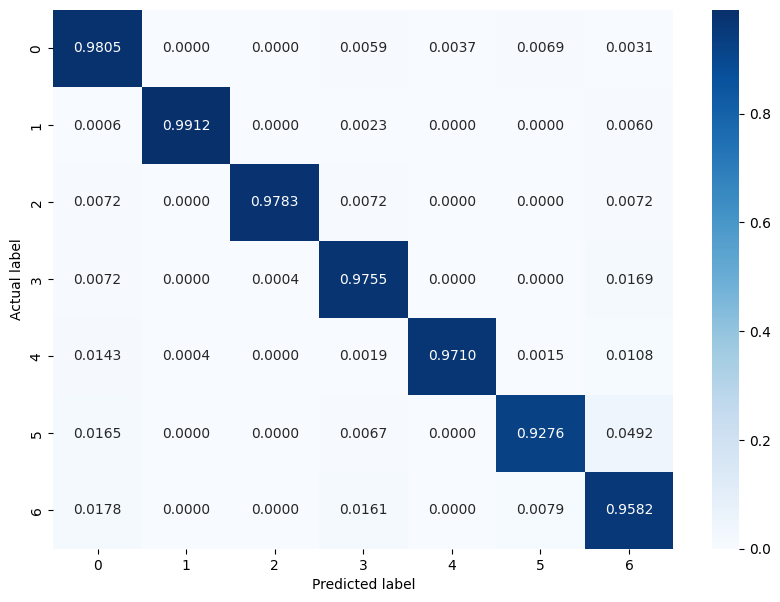

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import numpy as np

# 计算混淆矩阵
cm = confusion_matrix(label_array, predict_array)

# 将混淆矩阵转换为正确率矩阵
cm_rate = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 绘制热图
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rate, annot=True, fmt='.4f', cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
# 保存图像
# plt.savefig('/content/drive/MyDrive/Figure/confusion_matrix_NSL-KDD.png')  # 指定保存路径和文件名

# 显示图像
plt.show()


In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# Assuming predict_array and label_array are already defined as shown in your code

# Calculate Accuracy
accuracy = accuracy_score(label_array, predict_array)
print("Accuracy:", accuracy)

# Calculate Precision
precision = precision_score(label_array, predict_array, average='weighted')
print("Precision:", precision)

# Calculate Recall
recall = recall_score(label_array, predict_array, average='weighted')
print("Recall:", recall)

# Calculate F1-Score
f1 = f1_score(label_array, predict_array, average='weighted')
print("F1-Score:", f1)


Accuracy: 0.9804169670575427
Precision: 0.9815368448443319
Recall: 0.9804169670575427
F1-Score: 0.9807093454790325


In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# Assuming predict_array and label_array are already defined as shown in your code

# Calculate Accuracy
accuracy = accuracy_score(label_array, predict_array)
print("Accuracy:", accuracy)

# Calculate Precision
precision = precision_score(label_array, predict_array, average='weighted')
print("Precision:", precision)

# Calculate Recall
recall = recall_score(label_array, predict_array, average='weighted')
print("Recall:", recall)

# Calculate F1-Score
f1 = f1_score(label_array, predict_array, average='weighted')
print("F1-Score:", f1)


Accuracy: 0.9804169670575427
Precision: 0.9815368448443319
Recall: 0.9804169670575427
F1-Score: 0.9807093454790325


In [22]:
from sklearn.metrics import confusion_matrix
import numpy as np

# 假设你已经有了真实标签和预测标签
# label_array, predict_array

# 计算混淆矩阵
cm = confusion_matrix(label_array, predict_array)

# 每个类别的准确率计算
class_accuracy = np.diag(cm) / cm.sum(axis=1)

# 打印每个类别的准确率
for i, acc in enumerate(class_accuracy):
    print(f"Accuracy of class {i}: {acc}")

Accuracy of class 0: 0.98046875
Accuracy of class 1: 0.9911612936187605
Accuracy of class 2: 0.9782608695652174
Accuracy of class 3: 0.9755067567567568
Accuracy of class 4: 0.9710479118626697
Accuracy of class 5: 0.9276429809358753
Accuracy of class 6: 0.9582232893157263


# 分界线

# NSL-KDD

## 数据预处理

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


NSL_KDD = pd.read_csv('/content/drive/MyDrive/NSL_KDD.csv',encoding='gbk')
NSL_KDD.columns = NSL_KDD.columns.str.strip()
NSL_KDD.replace([np.inf, -np.inf], np.nan, inplace=True)
NSL_KDD.dropna(inplace=True)

# 定义一个标签映射函数，它将每个攻击类型标签映射到相应的类别
def map_label_to_category(label):
    # 定义每个类别的攻击类型
    probe_attacks = ['satan', 'ipsweep', 'nmap', 'portsweep', 'mscan', 'saint']
    dos_attacks = ['neptune', 'smurf', 'back', 'teardrop', 'pod', 'land', 'apache2', 'processtable', 'mailbomb', 'snmpgetattack', 'httptunnel', 'worm', 'sqlattack', 'udpstorm']
    u2r_attacks = ['buffer_overflow', 'loadmodule', 'rootkit', 'perl', 'xterm', 'ps']
    r2l_attacks = ['guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezmaster', 'warezclient', 'spy', 'named', 'sendmail', 'snmpguess', 'xlock', 'xsnoop']

    # 检查标签是否在任何攻击类型列表中，并返回相应的类别
    if label in probe_attacks:
        return 'Probe'
    elif label in dos_attacks:
        return 'DoS'
    elif label in u2r_attacks:
        return 'U2R'
    elif label in r2l_attacks:
        return 'R2L'
    elif label == 'normal':
        return 'BENIGN'

NSL_KDD['label'] = NSL_KDD['labels'].apply(map_label_to_category)
# 检查新的类别分布
category_counts = NSL_KDD['label'].value_counts()
NSL_KDD['label'].value_counts()

values_list = ['BENIGN','Probe', 'DoS', 'U2R','R2L']
filtered_df = NSL_KDD[NSL_KDD['label'].isin(values_list)]


# 假设你有一个DataFrame叫做df，其中包含了上图中的数据
# 应用标签映射函数到数据集的每一行
NSL_KDD['label'] = NSL_KDD['labels'].apply(map_label_to_category)

pd_train_v1 = pd.read_csv('/content/drive/MyDrive/CVUEBA.csv',encoding='gbk')
pd_train_v1 = pd_train_v1.rename(columns={'attack': 'label'})


def get_label(Label):
    if Label == 0:
        return 'Normal'
    else:
        return 'Malicious'

pd_train_v1['label'] = pd_train_v1['label'].apply(get_label)
# pd_train_v1.drop(columns=['day'],inplace=True)

all_columns = set(filtered_df.columns) | set(pd_train_v1.columns)
filtered_df_v1 = filtered_df.reindex(columns=all_columns)
df_train_v2 = pd_train_v1.reindex(columns=all_columns)
pd_final = pd.concat([filtered_df_v1, df_train_v2], ignore_index=True)

nb_class = len(list(pd_final['label'].value_counts()))
pd_mini = pd_final.sample(n=len(pd_final))

object_cols = pd_mini.select_dtypes(include=['object']).columns.tolist()
object_cols.remove('label')

cat_si_step = ('si', SimpleImputer(strategy='constant', fill_value=-99))
cat_ohe_step = ('ohe', OrdinalEncoder()) #离散数据整数化处理
cat_steps = [cat_si_step, cat_ohe_step]

cat_pipe = Pipeline(cat_steps)
cat_cols = object_cols
cat_transformers = [('cat', cat_pipe, cat_cols)]

ct = ColumnTransformer(transformers=cat_transformers)


for column_name in cat_cols:
  pd_mini[column_name] = pd_mini[column_name].astype('str')
X_kdd_transformed = ct.fit_transform(pd_mini)
non_object_cols = pd_mini.select_dtypes(exclude=['object']).columns.tolist()
num_cols = non_object_cols
num_si_step = ('si', SimpleImputer(strategy='median'))
num_ss_step = ('ss', StandardScaler()) #均值-标准差归一化
num_steps = [num_si_step, num_ss_step]
num_pipe = Pipeline(num_steps)
num_transformers = [('num', num_pipe, num_cols)]
ct = ColumnTransformer(transformers=num_transformers)
X_num_transformed = ct.fit_transform(pd_mini)

transformers = [('cat', cat_pipe, cat_cols),
                ('num', num_pipe, num_cols)]

ct = ColumnTransformer(transformers=transformers)
datax = pd_mini.drop(columns=['label'])
x_all = ct.fit_transform(datax)
le = LabelEncoder()
y_all = le.fit_transform(pd_mini['label'])
y_all = y_all.reshape(-1,1)
data = np.concatenate((y_all.reshape(-1,1),x_all),axis=1)
c = []



In [ ]:
print(len(x_all))

172215


In [ ]:
# 重采样
print(np.unique(data[:,0], return_counts=True))
# #重采样
# for i in range(172215):
#     if data[i,0] == 2:
#         data = np.concatenate((data,np.tile(data[i,:],(80,1))))
#     if data[i, 0] == 5:
#         data = np.concatenate((data, np.tile(data[i, :], (80, 1))))
#     if data[i,0] == 6:
#         data = np.concatenate((data,np.tile(data[i,:],(80,1))))
# for i in range(172215):
#     if data[i,0] == 2:
#         data = np.concatenate((data,np.tile(data[i,:],(80,1))))
#     if data[i, 0] == 5:
#         data = np.concatenate((data, np.tile(data[i, :], (30, 1))))
#     if data[i,0] == 6:
#         data = np.concatenate((data,np.tile(data[i,:],(30,1))))
for i in range(172215):
    if data[i,0] == 2:
        data = np.concatenate((data,np.tile(data[i,:],(80,1))))
    # if data[i, 0] == 5:
    #     data = np.concatenate((data, np.tile(data[i, :], (10, 1))))
    if data[i,0] == 6:
        data = np.concatenate((data,np.tile(data[i,:],(10,1))))
print(np.unique(data[:,0], return_counts=True))

#转化为独热编码
def one_hot_encode(labels, num_classes):
    num_samples = len(labels)
    one_hot_labels = np.zeros((num_samples, num_classes))
    for i in range(num_samples):
        one_hot_labels[i, labels[i]] = 1
    return one_hot_labels

num_classes = 7
one_hot_labels = one_hot_encode(data[:,0].astype(int), num_classes)

x_train_NSL_KDD, x_test_NSL_KDD, y_train_NSL_KDD, y_test_NSL_KDD = train_test_split(data[:,1:], one_hot_labels,stratify=one_hot_labels, test_size=0.2, random_state=1)

(array([0., 1., 2., 3., 4., 5., 6.]), array([77054, 53700,    17, 23681, 14077,  3569,   117]))
(array([0., 1., 2., 3., 4., 5., 6.]), array([77054, 53700,  1377, 23681, 14077,  3569,  1287]))


In [ ]:
# 假设 le 是您用于编码原始标签的 LabelEncoder 实例
# 创建一个包含0到6的整数数组
encoded_labels = np.arange(0, 7)

# 使用 inverse_transform 方法将这些整数标签映射回原始标签
original_labels = le.inverse_transform(encoded_labels)

# 打印0-6对应的原始标签
for encoded_label, original_label in zip(encoded_labels, original_labels):
    print(f'{encoded_label} corresponds to {original_label}')


0 corresponds to BENIGN
1 corresponds to DoS
2 corresponds to Malicious
3 corresponds to Normal
4 corresponds to Probe
5 corresponds to R2L
6 corresponds to U2R


## 降维

In [ ]:
import numpy as np

# # 加载数据
# x_train = np.load('/content/drive/MyDrive/x_train.npy')
# x_test = np.load('/content/drive/MyDrive/x_test.npy')
# y_train = np.load('/content/drive/MyDrive/y_train.npy')
# y_test = np.load('/content/drive/MyDrive/y_test.npy')

# 打印特征数量
print('x_train_NSL_KDD features:', x_train_NSL_KDD.shape[1] if x_train_NSL_KDD.ndim > 1 else 1)
print('x_test_NSL_KDD features:', x_test_NSL_KDD.shape[1] if x_test_NSL_KDD.ndim > 1 else 1)
print('y_train_NSL_KDD features:', y_train_NSL_KDD.shape[1] if y_train_NSL_KDD.ndim > 1 else 1)
print('y_test_NSL_KDD features:', y_test_NSL_KDD.shape[1] if y_test_NSL_KDD.ndim > 1 else 1)


x_train_NSL_KDD features: 69
x_test_NSL_KDD features: 69
y_train_NSL_KDD features: 7
y_test_NSL_KDD features: 7


In [ ]:
from sklearn.ensemble import RandomForestRegressor
# 使用随机森林评估特征重要性
rf = RandomForestRegressor(n_estimators=100)
rf.fit(x_train_NSL_KDD, y_train_NSL_KDD)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(x_train_NSL_KDD.shape[1]):
    print(f"{f+1}. feature {indices[f]} (importance: {importances[indices[f]]})")

# 选择重要性最高的N个特征（这里N根据需要调整）
N = 67
selected_features_indices = indices[:N]


Feature ranking:
1. feature 2 (importance: 0.5502016205816797)
2. feature 5 (importance: 0.2418477396913482)
3. feature 38 (importance: 0.04933783321041447)
4. feature 55 (importance: 0.04771116122229907)
5. feature 3 (importance: 0.023838820196622524)
6. feature 17 (importance: 0.01825115609440887)
7. feature 31 (importance: 0.014408203400576072)
8. feature 6 (importance: 0.013455836766694691)
9. feature 32 (importance: 0.009386723676507298)
10. feature 47 (importance: 0.0063667328054423265)
11. feature 39 (importance: 0.005467813310123164)
12. feature 1 (importance: 0.005168155872007217)
13. feature 37 (importance: 0.003825982372557833)
14. feature 0 (importance: 0.0030229093102853207)
15. feature 40 (importance: 0.001359728952362741)
16. feature 9 (importance: 0.0008845058923187145)
17. feature 27 (importance: 0.000778099513017239)
18. feature 19 (importance: 0.0007140145903479182)
19. feature 7 (importance: 0.0006524003618033275)
20. feature 13 (importance: 0.0005689762706405404)
2

## 保存特征

In [ ]:
import numpy as np

# 从 x_train_NSL_KDD 中选择重要性最高的 N 个特征
x_train_NSL_KDD = x_train_NSL_KDD[:, selected_features_indices]

# 保存筛选出来的特征到新的文件
np.save('/content/drive/MyDrive/x_train_NSL_KDD.npy', x_train_NSL_KDD)
selected_features = np.load('/content/drive/MyDrive/x_train_NSL_KDD.npy')
print('x_train features:', x_train_NSL_KDD.shape[1] if x_train_NSL_KDD.ndim > 1 else 1)

x_train features: 67


In [ ]:
# 从 x_train 中选择重要性最高的 N 个特征
x_test_NSL_KDD = x_test_NSL_KDD[:, selected_features_indices]

# 保存筛选出来的特征到新的文件
np.save('/content/drive/MyDrive/x_test_NSL_KDD.npy', x_test_NSL_KDD)
selected_features = np.load('/content/drive/MyDrive/x_test_NSL_KDD.npy')
print('x_train features:', x_test_NSL_KDD.shape[1] if x_test_NSL_KDD.ndim > 1 else 1)

x_train features: 67


In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

## 模型

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

Using cuda device
[ 0.32397502  0.46487098 18.12895529  1.05416036  1.77335877  6.9945563
 19.3967144 ]
Epoch 1
-------------------------------
train 1.5778647247892226 acc 32.8385647658016
test 4.481048180573229 acc 60.73707402214656
Higher accuracy found (60.74%). Model saved.
Epoch 2
-------------------------------
train 0.9887745121534723 acc 76.4528312684197
test 2.4257293922313745 acc 82.15113451028641
Higher accuracy found (82.15%). Model saved.
Epoch 3
-------------------------------
train 0.6378646450538705 acc 88.11625511459556
test 2.924484335425971 acc 87.42739420298149
Higher accuracy found (87.43%). Model saved.
Epoch 4
-------------------------------
train 0.45756935301053264 acc 90.03977223954905
test 16.923507505568907 acc 87.89378809121864
Higher accuracy found (87.89%). Model saved.
Epoch 5
-------------------------------
train 0.35920897659159057 acc 90.70931929382814
test 6.588369439693465 acc 87.92240121319637
Higher accuracy found (87.92%). Model saved.
Epoch 6
-

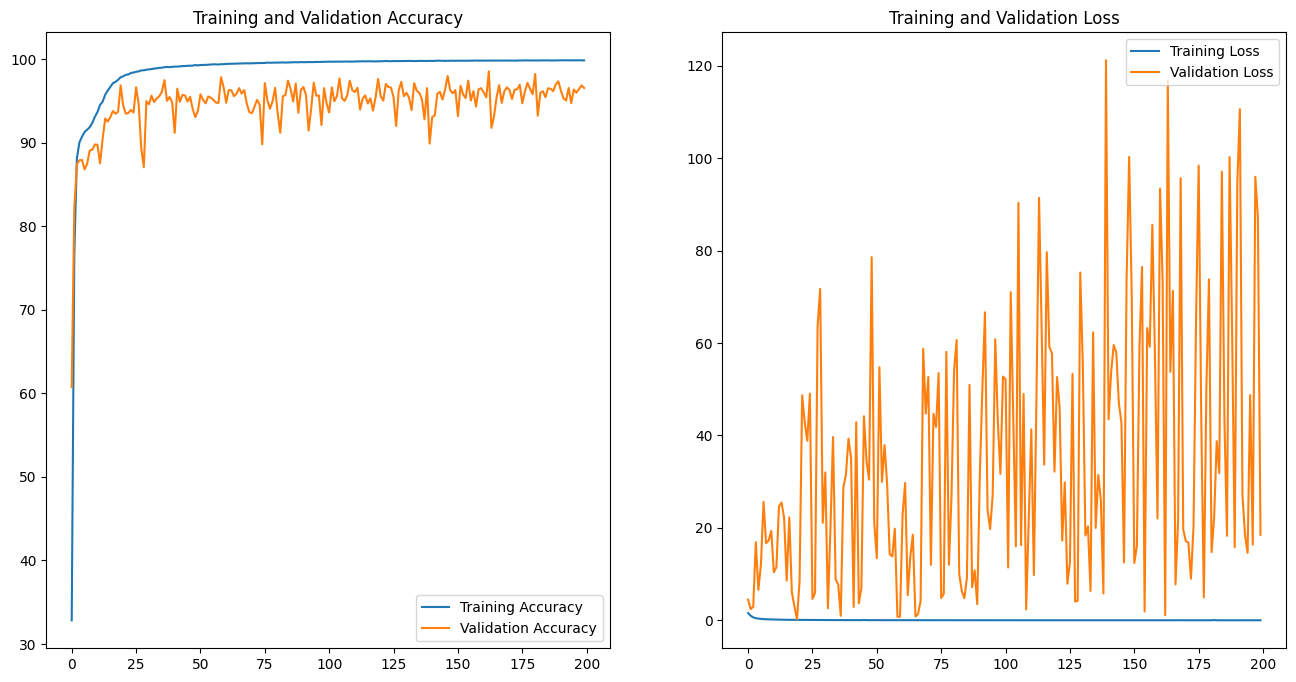

预测正确率: 0.9853786946693753


In [ ]:
x_train_NSL_KDD = np.load('/content/drive/MyDrive/x_train_NSL_KDD.npy')
x_test_NSL_KDD = np.load('/content/drive/MyDrive/x_test_NSL_KDD.npy')




train_ds = TensorDataset(torch.tensor(x_train_NSL_KDD).float(), torch.tensor(y_train_NSL_KDD).long())
test_ds = TensorDataset(torch.tensor(x_test_NSL_KDD).float(), torch.tensor(y_test_NSL_KDD).long())


class SelfAttention(nn.Module):
    def __init__(self, dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)

    def forward(self, x):
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)
        attention = F.softmax(q @ k.transpose(-2, -1) / x.size(-1)**0.5, dim=-1)
        return attention @ v
class DNNModel(nn.Module):
    def __init__(self, dim_num, nb_class, dropout_num, dropout_p):
        super().__init__()
        self.nor = nn.BatchNorm1d(dim_num)
        self.attention = SelfAttention(dim_num)
        self.lin1 = nn.Linear(dim_num, 512)  # Increase size
        self.lin2 = nn.Linear(dim_num + 512, 256)  # Adjust accordingly
        self.lin3 = nn.Linear(dim_num + 512 + 256, 128)  # Adjust accordingly
        self.lin4 = nn.Linear(dim_num + 512 + 256 + 128, 64)  # Adjust accordingly
        self.lin5 = nn.Linear(dim_num + 512 + 256 + 128 + 64, 32)  # Adjust accordingly
        self.lin6 = nn.Linear(dim_num + 512 + 256 + 128 + 64 + 32, 16)  # New layer
        self.lin7 = nn.Linear(dim_num + 512 + 256 + 128 + 64 + 32 + 16, 8)  # New layer
        # Adjust final layer to include input from all previous layers
        self.fc = nn.Linear(dim_num + 512 + 256 + 128 + 64 + 32 + 16 + 8, nb_class)
        self.flatten = nn.Flatten()
        self.dropouts = nn.ModuleList([nn.Dropout(dropout_p) for _ in range(dropout_num)])

    def forward(self, x):
        x = self.nor(x)
        attention_out = self.attention(x) + x

        out1 = F.relu(self.lin1(attention_out))
        concat1 = torch.cat([attention_out, out1], dim=1)

        out2 = F.relu(self.lin2(concat1))
        concat2 = torch.cat([concat1, out2], dim=1)

        out3 = F.relu(self.lin3(concat2))
        concat3 = torch.cat([concat2, out3], dim=1)

        out4 = F.relu(self.lin4(concat3))
        concat4 = torch.cat([concat3, out4], dim=1)

        out5 = F.relu(self.lin5(concat4))
        concat5 = torch.cat([concat4, out5], dim=1)

        out6 = F.relu(self.lin6(concat5))
        concat6 = torch.cat([concat5, out6], dim=1)

        out7 = F.relu(self.lin7(concat6))
        concat7 = torch.cat([concat6, out7], dim=1)

        flat_out = self.flatten(concat7)

        if len(self.dropouts) == 0:
            return self.fc(flat_out)
        else:
            out = None
            for i, dropout in enumerate(self.dropouts):
                if i == 0:
                    out = dropout(flat_out)
                    out = self.fc(out)
                else:
                    temp_out = dropout(flat_out)
                    out += self.fc(temp_out)
            return out / len(self.dropouts)

batch_size = 512
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


def train(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.to(torch.float32)
        loss = loss_fn(outputs, labels)  # 使用交叉熵损失函数计算损失
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels.argmax(dim=1)).sum().item()

    train_loss = total_loss / len(dataloader)
    train_acc = 100. * correct / total
    print('train', train_loss, 'acc', train_acc)
    return train_loss, train_acc

def test(dataloader, model, loss_fn):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            labels = labels.to(torch.float32)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels.argmax(dim=1)).sum().item()

    test_loss = total_loss / len(dataloader)
    test_acc = 100. * correct / total
    print('test', test_loss, 'acc', test_acc)
    return test_loss, test_acc


device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

dnn_model = DNNModel(dim_num=67, nb_class=7, dropout_num=8, dropout_p=0.5).to(device)
# [77054, 53700,  1377, 23681, 14077,  3569,  1287]
# [77054, 53700,  1377, 23681, 14077,  3569,  1287]
samples_per_class = np.array([77054, 53700,  1377, 23681, 14077,  3569,  1287])
total_samples = samples_per_class.sum()
weights = total_samples / (len(samples_per_class) * samples_per_class)
print(weights)
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float).to(device))
# loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dnn_model.parameters(), lr= 1e-5, betas = (0.88, 0.98), weight_decay = 1e-6)


epochs = 200
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

best_accuracy = 0.0
#
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_correct = train(train_dl, dnn_model, loss_fn, optimizer)
    test_loss, test_correct = test(test_dl, dnn_model, loss_fn)

    if test_correct > best_accuracy:
        best_accuracy = test_correct
        torch.save(dnn_model.state_dict(), '/content/drive/MyDrive/best_dnn_model.pth') #/content/drive/MyDrive/
        print(f"Higher accuracy found ({best_accuracy:.2f}%). Model saved.")

    train_loss_list.append(train_loss)
    train_acc_list.append(train_correct)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_correct)

acc = train_acc_list
val_acc = test_acc_list

loss = train_loss_list
val_loss = test_loss_list
epochs_range = range(epochs)

# plt.figure(figsize=(16, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

predict_list = []  # 存储预测结果
label_list = []  # 存储真实标签
predict_pro_list = []  # 存储预测概率

# 创建模型实例

# 加载最优模型参数
dnn_model.load_state_dict(torch.load('/content/drive/MyDrive/best_dnn_model.pth'))
dnn_model.eval()
m_softmax = nn.Softmax(dim=1)  # 定义softmax函数用于计算概率


# 遍历测试集
for (x, y) in test_dl:
    x = x.to(device)
    y = y.to(device)

    # 使用最优模型进行预测
    predict_score = dnn_model(x)
    predict_pro = m_softmax(predict_score)
    predict_label = torch.argmax(predict_score, dim=1)
    y = y.argmax(dim=1)
    # 将预测结果和真实标签添加到相应的列表中
    predict_list.append(predict_label.cpu().numpy())
    label_list.append(y.cpu().numpy())

# 将列表转换为数组
predict_array = np.concatenate(predict_list)
label_array = np.concatenate(label_list)

# 将独热编码转换为位置索引

# # 计算正确预测的样本数
correct_predictions = (predict_array == label_array).sum()
# # 计算总样本数
total_samples = len(label_array)  # 使用 label_index 的长度
# # 计算正确率
accuracy = correct_predictions / total_samples
#
print("预测正确率:", accuracy)


## 分类报告

In [ ]:
# 加载最优模型参数
dnn_model.load_state_dict(torch.load('/content/drive/MyDrive/best_dnn_model.pth'))
# dnn_model.load_state_dict(torch.load('/content/best_dnn_model.pth'))
dnn_model.eval()
m_softmax = nn.Softmax(dim=1)  # 定义softmax函数用于计算概率


# 遍历测试集
for (x, y) in test_dl:
    x = x.to(device)
    y = y.to(device)

    # 使用最优模型进行预测
    predict_score = dnn_model(x)
    predict_pro = m_softmax(predict_score)
    predict_label = torch.argmax(predict_score, dim=1)
    y = y.argmax(dim=1)
    # 将预测结果和真实标签添加到相应的列表中
    predict_list.append(predict_label.cpu().numpy())
    label_list.append(y.cpu().numpy())

# 将列表转换为数组
predict_array = np.concatenate(predict_list)
label_array = np.concatenate(label_list)

# 将独热编码转换为位置索引

# # 计算正确预测的样本数
correct_predictions = (predict_array == label_array).sum()
# # 计算总样本数
total_samples = len(label_array)  # 使用 label_index 的长度
# # 计算正确率
accuracy = correct_predictions / total_samples
#
print("预测正确率:", accuracy)
#

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


# 将列表转换为数组
predict_array = np.concatenate(predict_list)
label_array = np.concatenate(label_list)

# 计算正确预测的样本数
correct_predictions = (predict_array == label_array).sum()
# 计算总样本数
total_samples = len(label_array)
# 计算正确率
accuracy = correct_predictions / total_samples
print("预测正确率: {:.4f}".format(accuracy))

# 打印分类报告
# 在classification_report中设置digits参数为4，以设置小数点后四位的精度
print("分类报告:")
print(classification_report(label_array, predict_array, digits=4))

# 计算并打印混淆矩阵
# 注意：混淆矩阵是整数，所以不需要设置小数位数
print("混淆矩阵:")
cm = confusion_matrix(label_array, predict_array)
print(cm)


In [ ]:
# 计算并打印混淆矩阵
print("混淆矩阵:")
cm = confusion_matrix(label_array, predict_array)

# 计算假警报率
FP = cm[1][0]
TN = cm[1][1]
false_alarm_rate = FP / (FP + TN)
print("假警报率: {:.4f}".format(false_alarm_rate))


In [ ]:
# 计算并打印混淆矩阵
print("混淆矩阵:")
cm = confusion_matrix(label_array, predict_array)

# 计算检测率
TP = cm[0][0]
FN = cm[0][1]
detection_rate = TP / (TP + FN)
print("检测率: {:.4f}".format(detection_rate))


In [ ]:
# 计算并打印混淆矩阵
print("混淆矩阵:")
cm = confusion_matrix(label_array, predict_array)

# 计算假负例率
TP = cm[0][0]
FN = cm[0][1]
false_negative_rate = FN / (TP + FN)
print("假负例率: {:.4f}".format(false_negative_rate))


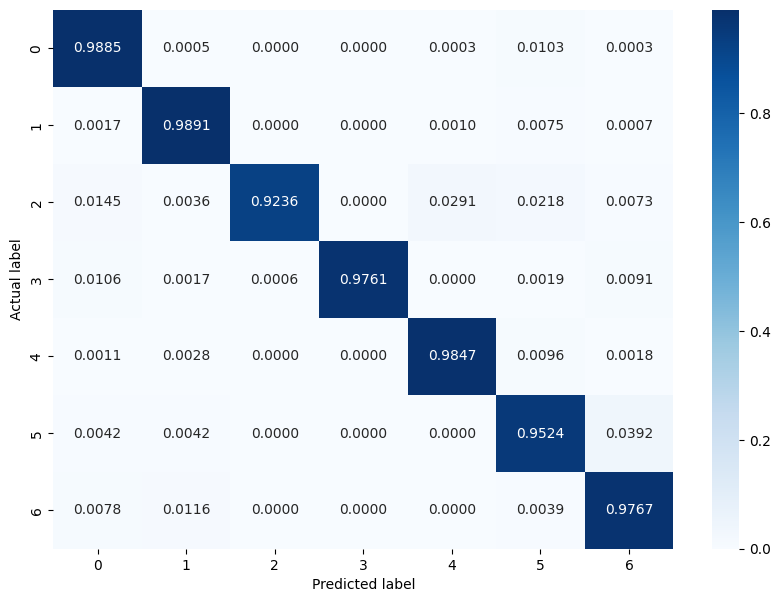

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import numpy as np

# 计算混淆矩阵
cm = confusion_matrix(label_array, predict_array)

# 将混淆矩阵转换为正确率矩阵
cm_rate = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 绘制热图
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rate, annot=True, fmt='.4f', cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
# 保存图像
# plt.savefig('/content/drive/MyDrive/Figure/confusion_matrix_NSL-KDD.png')  # 指定保存路径和文件名

# 显示图像
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# Assuming predict_array and label_array are already defined as shown in your code

# Calculate Accuracy
accuracy = accuracy_score(label_array, predict_array)
print("Accuracy:", accuracy)

# Calculate Precision
precision = precision_score(label_array, predict_array, average='weighted')
print("Precision:", precision)

# Calculate Recall
recall = recall_score(label_array, predict_array, average='weighted')
print("Recall:", recall)

# Calculate F1-Score
f1 = f1_score(label_array, predict_array, average='weighted')
print("F1-Score:", f1)


Accuracy: 0.9853786946693753
Precision: 0.9880726072448677
Recall: 0.9853786946693753
F1-Score: 0.9861898541521202


In [ ]:
# 计算每个类别的精确度、召回率和F1分数
precision_per_class = precision_score(label_array, predict_array, average=None)
recall_per_class = recall_score(label_array, predict_array, average=None)
f1_per_class = f1_score(label_array, predict_array, average=None)

# 打印每个类别的精确度、召回率和F1分数
print("Precision per class:", precision_per_class)
print("Recall per class:", recall_per_class)
print("F1-Score per class:", f1_per_class)


Precision per class: [0.99477602 0.99709029 0.98832685 1.         0.99141631 0.70612669
 0.73684211]
Recall per class: [0.9885147  0.98910615 0.92363636 0.9761402  0.98472469 0.95238095
 0.97674419]
F1-Score per class: [0.99163548 0.99308217 0.95488722 0.98792606 0.98805917 0.81097197
 0.84      ]


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# 创建一个布尔掩码，其中标签不为2和3的为True，否则为False
mask = ~((label_array == 2) | (label_array == 3))

# 应用掩码，去除标签为2和3的条目
filtered_label_array = label_array[mask]
filtered_predict_array = predict_array[mask]

# 重新计算指标
# Calculate Accuracy
accuracy_filtered = accuracy_score(filtered_label_array, filtered_predict_array)
print("Filtered Accuracy:", accuracy_filtered)

# Calculate Precision
precision_filtered = precision_score(filtered_label_array, filtered_predict_array, average='weighted', zero_division=0)
print("Filtered Precision:", precision_filtered)

# Calculate Recall
recall_filtered = recall_score(filtered_label_array, filtered_predict_array, average='weighted', zero_division=0)
print("Filtered Recall:", recall_filtered)

# Calculate F1-Score
f1_filtered = f1_score(filtered_label_array, filtered_predict_array, average='weighted', zero_division=0)
print("Filtered F1-Score:", f1_filtered)


Filtered Accuracy: 0.9874073084374374
Filtered Precision: 0.9897939885640861
Filtered Recall: 0.9874073084374374
Filtered F1-Score: 0.9881455412082175


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# 假设你已经有了真实标签和预测标签
# label_array, predict_array

# 计算混淆矩阵
cm = confusion_matrix(label_array, predict_array)

# 每个类别的准确率计算
class_accuracy = np.diag(cm) / cm.sum(axis=1)

# 打印每个类别的准确率
for i, acc in enumerate(class_accuracy):
    print(f"Accuracy of class {i}: {acc}")


Accuracy of class 0: 0.9885146972941405
Accuracy of class 1: 0.9891061452513966
Accuracy of class 2: 0.9236363636363636
Accuracy of class 3: 0.9761402027027027
Accuracy of class 4: 0.9847246891651865
Accuracy of class 5: 0.9523809523809523
Accuracy of class 6: 0.9767441860465116


# --------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------------------------

# 随便

# CSE-CIC-IDS2018


### 下载数据

In [ ]:
!cp /content/drive/MyDrive/kaggle.json /content/

In [ ]:
!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ekkykharismadhany/csecicids2018-cleaned

csecicids2018-cleaned.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/csecicids2018-cleaned.zip

Archive:  /content/csecicids2018-cleaned.zip
replace cleaned_ids2018_sampled.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: cleaned_ids2018_sampled.csv  


### 数据处理

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


C2018 = pd.read_csv('/content/cleaned_ids2018_sampled.csv',encoding='gbk')
C2018.columns = C2018.columns.str.strip()
C2018.replace([np.inf, -np.inf], np.nan, inplace=True)
C2018.dropna(inplace=True)

# def map_label_to_category(label):
#     probe_attacks = ['ipsweep', 'nmap', 'portsweep']
#     dos_attacks = ['smurf', 'neptune', 'back','teardrop','pod','land']
#     u2r_attacks = ['buffer_overflow','rootkit','loadmodule','perl']
#     r2l_attacks = ['ftp_write', 'imap', 'multihop','phf', 'spy', 'warezclient','warezmaster','guess_passwd']

#     if label in probe_attacks:
#         return 'Probe'
#     elif label in dos_attacks:
#         return 'DoS'
#     elif label in u2r_attacks:
#         return 'U2R'
#     elif label in r2l_attacks:
#         return 'R2L'
#     elif label == 'normal':
#         return 'BENIGN'

def get_label_v1(item):
  if item == 1:
    return 'a'
  else:
    return 'b'
C2018['label'] = C2018['Label'].apply(get_label_v1)
C2018.label.value_counts()


C2018['label'].value_counts()



C2018.drop(columns=['Label'],inplace=True)

# values_list = ['BENIGN','Probe', 'DoS', 'U2R','R2L']
# filtered_df = kddcup99[kddcup99['label'].isin(values_list)]

pd_train_v1 = pd.read_csv('/content/drive/MyDrive/CVUEBA.csv',encoding='gbk')
pd_train_v1 = pd_train_v1.rename(columns={'attack': 'label'})


def get_label(Label):
    if Label == 0:
        return 'Normal'
    else:
        return 'Malicious'

pd_train_v1['label'] = pd_train_v1['label'].apply(get_label)

all_columns = set(C2018.columns) | set(pd_train_v1.columns)
# C2018 = C2018.reindex(columns=all_columns)
# df_train_v2 = pd_train_v1.reindex(columns=all_columns)
df_2018_v2 = C2018.reindex(columns=all_columns)
df_train_v2 = pd_train_v1.reindex(columns=all_columns)
pd_final = pd.concat([df_2018_v2, df_train_v2], ignore_index=True)

nb_class = len(list(pd_final['label'].value_counts()))
pd_mini = pd_final.sample(n=len(pd_final))

object_cols = pd_mini.select_dtypes(include=['object']).columns.tolist()
object_cols.remove('label')

cat_si_step = ('si', SimpleImputer(strategy='constant', fill_value=-99))
cat_ohe_step = ('ohe', OrdinalEncoder()) #离散数据整数化处理
cat_steps = [cat_si_step, cat_ohe_step]

cat_pipe = Pipeline(cat_steps)
cat_cols = object_cols
cat_transformers = [('cat', cat_pipe, cat_cols)]

ct = ColumnTransformer(transformers=cat_transformers)


for column_name in cat_cols:
  pd_mini[column_name] = pd_mini[column_name].astype('str')
X_kdd_transformed = ct.fit_transform(pd_mini)
non_object_cols = pd_mini.select_dtypes(exclude=['object']).columns.tolist()
num_cols = non_object_cols
num_si_step = ('si', SimpleImputer(strategy='median'))
num_ss_step = ('ss', StandardScaler()) #均值-标准差归一化
num_steps = [num_si_step, num_ss_step]
num_pipe = Pipeline(num_steps)
num_transformers = [('num', num_pipe, num_cols)]
ct = ColumnTransformer(transformers=num_transformers)
X_num_transformed = ct.fit_transform(pd_mini)

transformers = [('cat', cat_pipe, cat_cols),
                ('num', num_pipe, num_cols)]

ct = ColumnTransformer(transformers=transformers)
datax = pd_mini.drop(columns=['label'])
x_all = ct.fit_transform(datax)
le = LabelEncoder()
y_all = le.fit_transform(pd_mini['label'])
y_all = y_all.reshape(-1,1)
data = np.concatenate((y_all.reshape(-1,1),x_all),axis=1)
c = []
#重采样
# for i in range(len(pd_final)):
for i in range(len(pd_final)):
    if data[i,0] == 0:
        data = np.concatenate((data,np.tile(data[i,:],(80,1))))
    # if data[i, 0] == 4:
    #     data = np.concatenate((data, np.tile(data[i, :], (30, 1))))
    # if data[i, 0] == 5:
    #     data = np.concatenate((data, np.tile(data[i, :], (40, 1))))
    # if data[i,0] == 6:
    #     data = np.concatenate((data,np.tile(data[i,:],(800,1))))
print(np.unique(data[:,0], return_counts=True))
#转化为独热编码
def one_hot_encode(labels, num_classes):
    num_samples = len(labels)
    one_hot_labels = np.zeros((num_samples, num_classes))
    for i in range(num_samples):
        one_hot_labels[i, labels[i]] = 1
    return one_hot_labels

num_classes = 4
one_hot_labels = one_hot_encode(data[:,0].astype(int), num_classes)

x_train_2018, x_test_2018, y_train_2018, y_test_2018 = train_test_split(data[:,1:], one_hot_labels,stratify=one_hot_labels, test_size=0.1, random_state=1)


(array([0., 1., 2., 3.]), array([  1377,  23681, 971016, 281830]))


## 降维

In [ ]:
import numpy as np

# 打印特征数量
print('x_train features:', x_train_2018.shape[1] if x_train_2018.ndim > 1 else 1)
print('x_test features:', x_test_2018.shape[1] if x_test_2018.ndim > 1 else 1)
print('y_train features:', y_train_2018.shape[1] if y_train_2018.ndim > 1 else 1)
print('y_test features:', y_test_2018.shape[1] if y_test_2018.ndim > 1 else 1)

x_train features: 105
x_test features: 105
y_train features: 4
y_test features: 4


In [ ]:
from sklearn.ensemble import RandomForestRegressor
# 使用随机森林评估特征重要性
rf = RandomForestRegressor(n_estimators=100)
rf.fit(x_train_2018, y_train_2018)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(x_train_2018.shape[1]):
    print(f"{f+1}. feature {indices[f]} (importance: {importances[indices[f]]})")

# 选择重要性最高的N个特征（这里N根据需要调整）
N = 67
selected_features_indices = indices[:N]

KeyboardInterrupt: 

In [ ]:
# 从 x_train 中选择重要性最高的 N 个特征
x_test_2018 = x_test_2018[:, selected_features_indices]

# 保存筛选出来的特征到新的文件
np.save('/content/drive/MyDrive/x_test_2018.npy', x_test_2018)
selected_features = np.load('/content/drive/MyDrive/x_test_2018.npy')
print('x_test_2018 features:', x_test_2018.shape[1] if x_test_2018.ndim > 1 else 1)

In [ ]:
# 从 x_train 中选择重要性最高的 N 个特征
x_train_2018 = x_train_2018[:, selected_features_indices]

# 保存筛选出来的特征到新的文件
np.save('/content/drive/MyDrive/x_train_2018.npy', x_train_2018)
selected_features = np.load('/content/drive/MyDrive/x_train_2018.npy')
print('x_train_2018 features:', x_train_2018.shape[1] if x_train_2018.ndim > 1 else 1)

In [ ]:
!pip install torch

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
x_train_2018 = np.load('/content/drive/MyDrive/x_train_2018.npy')
x_test_2018 = np.load('/content/drive/MyDrive/x_test_2018.npy')


In [ ]:
train_ds = TensorDataset(torch.tensor(x_train_2018).float(), torch.tensor(y_train_2018).long())
test_ds = TensorDataset(torch.tensor(x_test_2018).float(), torch.tensor(y_test_2018).long())


## 保存特征

In [ ]:
import numpy as np

# 从 x_train 中选择重要性最高的 N 个特征
x_train_2018 = x_train_2018[:, selected_features_indices]

# 保存筛选出来的特征到新的文件
np.save('/content/drive/MyDrive/x_train_2018.npy', x_train_2018)
selected_features = np.load('/content/drive/MyDrive/x_train_2018.npy')
print('x_train_2018 features:', x_train_2018.shape[1] if x_train_2018.ndim > 1 else 1)

In [ ]:
# 从 x_train 中选择重要性最高的 N 个特征
x_test_2018 = x_test_2018[:, selected_features_indices]

# 保存筛选出来的特征到新的文件
np.save('/content/drive/MyDrive/x_test_2018.npy', x_test_2018)
selected_features = np.load('/content/drive/MyDrive/x_test_2018.npy')
print('x_train features:', x_test_2018.shape[1] if x_test_2018.ndim > 1 else 1)

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

## 模型

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [ ]:
x_train_2018 = np.load('/content/drive/MyDrive/x_train_2018.npy')
x_test_2018 = np.load('/content/drive/MyDrive/x_test_2018.npy')




train_ds = TensorDataset(torch.tensor(x_train_2018).float(), torch.tensor(y_train_2018).long())
test_ds = TensorDataset(torch.tensor(x_test_2018).float(), torch.tensor(y_test_2018).long())


class SelfAttention(nn.Module):
    def __init__(self, dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)

    def forward(self, x):
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)
        attention = F.softmax(q @ k.transpose(-2, -1) / x.size(-1)**0.5, dim=-1)
        return attention @ v
class DNNModel(nn.Module):
    def __init__(self, dim_num, nb_class, dropout_num, dropout_p):
        super().__init__()
        self.nor = nn.BatchNorm1d(dim_num)
        self.attention = SelfAttention(dim_num)
        self.lin1 = nn.Linear(dim_num, 512)  # Increase size
        self.lin2 = nn.Linear(dim_num + 512, 256)  # Adjust accordingly
        self.lin3 = nn.Linear(dim_num + 512 + 256, 128)  # Adjust accordingly
        self.lin4 = nn.Linear(dim_num + 512 + 256 + 128, 64)  # Adjust accordingly
        self.lin5 = nn.Linear(dim_num + 512 + 256 + 128 + 64, 32)  # Adjust accordingly
        self.lin6 = nn.Linear(dim_num + 512 + 256 + 128 + 64 + 32, 16)  # New layer
        self.lin7 = nn.Linear(dim_num + 512 + 256 + 128 + 64 + 32 + 16, 8)  # New layer
        # Adjust final layer to include input from all previous layers
        self.fc = nn.Linear(dim_num + 512 + 256 + 128 + 64 + 32 + 16 + 8, nb_class)
        self.flatten = nn.Flatten()
        self.dropouts = nn.ModuleList([nn.Dropout(dropout_p) for _ in range(dropout_num)])

    def forward(self, x):
        x = self.nor(x)
        attention_out = self.attention(x) + x

        out1 = F.relu(self.lin1(attention_out))
        concat1 = torch.cat([attention_out, out1], dim=1)

        out2 = F.relu(self.lin2(concat1))
        concat2 = torch.cat([concat1, out2], dim=1)

        out3 = F.relu(self.lin3(concat2))
        concat3 = torch.cat([concat2, out3], dim=1)

        out4 = F.relu(self.lin4(concat3))
        concat4 = torch.cat([concat3, out4], dim=1)

        out5 = F.relu(self.lin5(concat4))
        concat5 = torch.cat([concat4, out5], dim=1)

        out6 = F.relu(self.lin6(concat5))
        concat6 = torch.cat([concat5, out6], dim=1)

        out7 = F.relu(self.lin7(concat6))
        concat7 = torch.cat([concat6, out7], dim=1)

        flat_out = self.flatten(concat7)

        if len(self.dropouts) == 0:
            return self.fc(flat_out)
        else:
            out = None
            for i, dropout in enumerate(self.dropouts):
                if i == 0:
                    out = dropout(flat_out)
                    out = self.fc(out)
                else:
                    temp_out = dropout(flat_out)
                    out += self.fc(temp_out)
            return out / len(self.dropouts)

batch_size = 512
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


def train(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.to(torch.float32)
        loss = loss_fn(outputs, labels)  # 使用交叉熵损失函数计算损失
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels.argmax(dim=1)).sum().item()

    train_loss = total_loss / len(dataloader)
    train_acc = 100. * correct / total
    print('train', train_loss, 'acc', train_acc)
    return train_loss, train_acc

def test(dataloader, model, loss_fn):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            labels = labels.to(torch.float32)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels.argmax(dim=1)).sum().item()

    test_loss = total_loss / len(dataloader)
    test_acc = 100. * correct / total
    print('test', test_loss, 'acc', test_acc)
    return test_loss, test_acc


device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

dnn_model = DNNModel(dim_num=67, nb_class=7, dropout_num=8, dropout_p=0.5).to(device)
# [77054, 53700,  1377, 23681, 14077,  3569,  1287]
# [77054, 53700,  1377, 23681, 14077,  3569,  1287]
samples_per_class = np.array([77054, 53700,  1377, 23681, 14077,  3569,  1287])
total_samples = samples_per_class.sum()
weights = total_samples / (len(samples_per_class) * samples_per_class)
print(weights)
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float).to(device))
# loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dnn_model.parameters(), lr= 1e-5, betas = (0.88, 0.98), weight_decay = 1e-6)


epochs = 200
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

best_accuracy = 0.0
#
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_correct = train(train_dl, dnn_model, loss_fn, optimizer)
    test_loss, test_correct = test(test_dl, dnn_model, loss_fn)

    if test_correct > best_accuracy:
        best_accuracy = test_correct
        torch.save(dnn_model.state_dict(), '/content/drive/MyDrive/best_dnn_model_2018.pth') #/content/drive/MyDrive/
        print(f"Higher accuracy found ({best_accuracy:.2f}%). Model saved.")

    train_loss_list.append(train_loss)
    train_acc_list.append(train_correct)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_correct)

acc = train_acc_list
val_acc = test_acc_list

loss = train_loss_list
val_loss = test_loss_list
epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

predict_list = []  # 存储预测结果
label_list = []  # 存储真实标签
predict_pro_list = []  # 存储预测概率

# 创建模型实例

# 加载最优模型参数
dnn_model.load_state_dict(torch.load('/content/drive/MyDrive/best_dnn_model_2018.pth'))
dnn_model.eval()
m_softmax = nn.Softmax(dim=1)  # 定义softmax函数用于计算概率


# 遍历测试集
for (x, y) in test_dl:
    x = x.to(device)
    y = y.to(device)

    # 使用最优模型进行预测
    predict_score = dnn_model(x)
    predict_pro = m_softmax(predict_score)
    predict_label = torch.argmax(predict_score, dim=1)
    y = y.argmax(dim=1)
    # 将预测结果和真实标签添加到相应的列表中
    predict_list.append(predict_label.cpu().numpy())
    label_list.append(y.cpu().numpy())

# 将列表转换为数组
predict_array = np.concatenate(predict_list)
label_array = np.concatenate(label_list)

# 将独热编码转换为位置索引

# # 计算正确预测的样本数
correct_predictions = (predict_array == label_array).sum()
# # 计算总样本数
total_samples = len(label_array)  # 使用 label_index 的长度
# # 计算正确率
accuracy = correct_predictions / total_samples
#
print("预测正确率:", accuracy)


## 分类报告

In [ ]:
# 加载最优模型参数
dnn_model.load_state_dict(torch.load('/content/drive/MyDrive/best_dnn_model_2018.pth'))
# dnn_model.load_state_dict(torch.load('/content/best_dnn_model.pth'))
dnn_model.eval()
m_softmax = nn.Softmax(dim=1)  # 定义softmax函数用于计算概率


# 遍历测试集
for (x, y) in test_dl:
    x = x.to(device)
    y = y.to(device)

    # 使用最优模型进行预测
    predict_score = dnn_model(x)
    predict_pro = m_softmax(predict_score)
    predict_label = torch.argmax(predict_score, dim=1)
    y = y.argmax(dim=1)
    # 将预测结果和真实标签添加到相应的列表中
    predict_list.append(predict_label.cpu().numpy())
    label_list.append(y.cpu().numpy())

# 将列表转换为数组
predict_array = np.concatenate(predict_list)
label_array = np.concatenate(label_list)

# 将独热编码转换为位置索引

# # 计算正确预测的样本数
correct_predictions = (predict_array == label_array).sum()
# # 计算总样本数
total_samples = len(label_array)  # 使用 label_index 的长度
# # 计算正确率
accuracy = correct_predictions / total_samples
#
print("预测正确率:", accuracy)
#

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


# 将列表转换为数组
predict_array = np.concatenate(predict_list)
label_array = np.concatenate(label_list)

# 计算正确预测的样本数
correct_predictions = (predict_array == label_array).sum()
# 计算总样本数
total_samples = len(label_array)
# 计算正确率
accuracy = correct_predictions / total_samples
print("预测正确率: {:.4f}".format(accuracy))

# 打印分类报告
# 在classification_report中设置digits参数为4，以设置小数点后四位的精度
print("分类报告:")
print(classification_report(label_array, predict_array, digits=4))

# 计算并打印混淆矩阵
# 注意：混淆矩阵是整数，所以不需要设置小数位数
print("混淆矩阵:")
cm = confusion_matrix(label_array, predict_array)
print(cm)


In [ ]:
# 计算并打印混淆矩阵
print("混淆矩阵:")
cm = confusion_matrix(label_array, predict_array)

# 计算假警报率
FP = cm[1][0]
TN = cm[1][1]
false_alarm_rate = FP / (FP + TN)
print("假警报率: {:.4f}".format(false_alarm_rate))


In [ ]:
# 计算并打印混淆矩阵
print("混淆矩阵:")
cm = confusion_matrix(label_array, predict_array)

# 计算检测率
TP = cm[0][0]
FN = cm[0][1]
detection_rate = TP / (TP + FN)
print("检测率: {:.4f}".format(detection_rate))


In [ ]:
# 计算并打印混淆矩阵
print("混淆矩阵:")
cm = confusion_matrix(label_array, predict_array)

# 计算假负例率
TP = cm[0][0]
FN = cm[0][1]
false_negative_rate = FN / (TP + FN)
print("假负例率: {:.4f}".format(false_negative_rate))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import numpy as np

# 计算混淆矩阵
cm = confusion_matrix(label_array, predict_array)

# 将混淆矩阵转换为正确率矩阵
cm_rate = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 绘制热图
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rate, annot=True, fmt='.4f', cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
# 保存图像
# plt.savefig('/content/drive/MyDrive/Figure/confusion_matrix_NSL-KDD.png')  # 指定保存路径和文件名

# 显示图像
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# Assuming predict_array and label_array are already defined as shown in your code

# Calculate Accuracy
accuracy = accuracy_score(label_array, predict_array)
print("Accuracy:", accuracy)

# Calculate Precision
precision = precision_score(label_array, predict_array, average='weighted')
print("Precision:", precision)

# Calculate Recall
recall = recall_score(label_array, predict_array, average='weighted')
print("Recall:", recall)

# Calculate F1-Score
f1 = f1_score(label_array, predict_array, average='weighted')
print("F1-Score:", f1)


In [ ]:
# 计算每个类别的精确度、召回率和F1分数
precision_per_class = precision_score(label_array, predict_array, average=None)
recall_per_class = recall_score(label_array, predict_array, average=None)
f1_per_class = f1_score(label_array, predict_array, average=None)

# 打印每个类别的精确度、召回率和F1分数
print("Precision per class:", precision_per_class)
print("Recall per class:", recall_per_class)
print("F1-Score per class:", f1_per_class)


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# 创建一个布尔掩码，其中标签不为2和3的为True，否则为False
mask = ~((label_array == 2) | (label_array == 3))

# 应用掩码，去除标签为2和3的条目
filtered_label_array = label_array[mask]
filtered_predict_array = predict_array[mask]

# 重新计算指标
# Calculate Accuracy
accuracy_filtered = accuracy_score(filtered_label_array, filtered_predict_array)
print("Filtered Accuracy:", accuracy_filtered)

# Calculate Precision
precision_filtered = precision_score(filtered_label_array, filtered_predict_array, average='weighted', zero_division=0)
print("Filtered Precision:", precision_filtered)

# Calculate Recall
recall_filtered = recall_score(filtered_label_array, filtered_predict_array, average='weighted', zero_division=0)
print("Filtered Recall:", recall_filtered)

# Calculate F1-Score
f1_filtered = f1_score(filtered_label_array, filtered_predict_array, average='weighted', zero_division=0)
print("Filtered F1-Score:", f1_filtered)


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# 假设你已经有了真实标签和预测标签
# label_array, predict_array

# 计算混淆矩阵
cm = confusion_matrix(label_array, predict_array)

# 每个类别的准确率计算
class_accuracy = np.diag(cm) / cm.sum(axis=1)

# 打印每个类别的准确率
for i, acc in enumerate(class_accuracy):
    print(f"Accuracy of class {i}: {acc}")


# 机器学习模型对比实验

#### SVM

In [ ]:
from sklearn.svm import SVC

# Create SVM classifier, here you can also specify parameters like 'kernel'
svm_classifier = SVC()

# Fit the classifier to the training data
svm_classifier.fit(x_train, y_train)

# Evaluate the classifier on the test data
accuracy = svm_classifier.score(x_test, y_test)
print("Accuracy:", accuracy)

# Make predictions
predict_labels = svm_classifier.predict(x_test)
print(predict_labels[:5])


#### MW

#### DT

In [ ]:
from sklearn import tree
# rf = RandomForestClassifier()
clf = tree.DecisionTreeClassifier()

clf.fit(x_train,y_train)
# clf.fit(x_train_new,y_train_new)

In [ ]:
clf.score(x_test,y_test)

In [ ]:
predict_label = clf.predict(x_test)
predict_label[:5]

In [ ]:
predict_score_list = clf.predict_proba(x_test)[:,1]
predict_score_list

In [ ]:
print(classification_report(y_test, predict_label,digits=4))

In [ ]:
cnf_matrix = confusion_matrix(y_test, predict_label)
cnf_matrix

In [ ]:
sns.heatmap(cnf_matrix, annot=True, fmt='g')

In [ ]:
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f')

#### RF

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=2)

rf.fit(x_train,y_train)

In [ ]:
rf.score(x_test,y_test)

In [ ]:
predict_label = rf.predict(x_test)
predict_label[:5]

In [ ]:
predict_score_list = rf.predict_proba(x_test)[:,1]
predict_score_list

In [ ]:
print(classification_report(y_test, predict_label,digits=4))

In [ ]:
cnf_matrix = confusion_matrix(y_test, predict_label)
cnf_matrix

In [ ]:
sns.heatmap(cnf_matrix, annot=True, fmt='g')

In [ ]:
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f')

#### LR

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

lr.fit(x_train,y_train)

In [ ]:
lr.score(x_test,y_test)

In [ ]:
predict_label = lr.predict(x_test)
predict_label[:5]

In [ ]:
predict_score_list = lr.predict_proba(x_test)[:,1]
predict_score_list

In [ ]:
print(classification_report(y_test, predict_label,digits=4))

In [ ]:
cnf_matrix = confusion_matrix(y_test, predict_label)
cnf_matrix

In [ ]:
sns.heatmap(cnf_matrix, annot=True, fmt='g')

In [ ]:
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f')

#### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# 创建KNN分类器，指定K值为3
knn_classifier = KNeighborsClassifier(n_neighbors=4)

knn_classifier.fit(x_train,y_train)

In [ ]:
knn_classifier.score(x_test,y_test)

In [ ]:
predict_label = knn_classifier.predict(x_test)
predict_label[:5]

In [ ]:
predict_score_list = knn_classifier.predict_proba(x_test)[:,1]
predict_score_list

In [ ]:
print(classification_report(y_test, predict_label,digits=4))

In [ ]:
cnf_matrix = confusion_matrix(y_test, predict_label)
cnf_matrix

In [ ]:
sns.heatmap(cnf_matrix, annot=True, fmt='g')

In [ ]:
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f')

#### XGBoost

In [ ]:
import xgboost as xgb
# 创建XGBoost分类器
xgb_classifier = xgb.XGBClassifier(n_estimators = 3)


xgb_classifier.fit(x_train,y_train)

In [ ]:
xgb_classifier.score(x_test,y_test)

In [ ]:
predict_label = xgb_classifier.predict(x_test)
predict_label[:5]

In [ ]:
predict_score_list = xgb_classifier.predict_proba(x_test)[:,1]
predict_score_list

In [ ]:
print(classification_report(y_test, predict_label,digits=4))

In [ ]:
cnf_matrix = confusion_matrix(y_test, predict_label)
cnf_matrix

In [ ]:
sns.heatmap(cnf_matrix, annot=True, fmt='g')

In [ ]:
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f')

# 对比试验

## dnn模型

### 构建模型

In [ ]:
class DNNModel(nn.Module):
    def __init__(self,):
        super().__init__()
        self.nor = nn.BatchNorm1d(dim_num)
        self.lin = nn.Linear(dim_num,8)
        self.out = nn.Linear(8, nb_class)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.nor(x)
        x= self.lin(x)
        x = self.flatten(x)
        x = self.out(x)

        return x
dnn_model = DNNModel().to(device)
# text_cnn(text)[0].shape,text_cnn(text)[1].shape,text_cnn(text)[2].shape

dnn_model(b_x.to(device)).shape

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dnn_model.parameters(), lr=1e-3)

### 训练和评估

In [ ]:
# 记得修改epoch
epochs = 3
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dl, dnn_model, loss_fn, optimizer)

    train_loss, train_correct = test(train_dl, dnn_model, loss_fn)
    test_loss, test_correct = test(test_dl, dnn_model, loss_fn)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_correct)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_correct)
print("Done!")

### 可视化训练过程

In [ ]:
acc = train_acc_list
val_acc = test_acc_list

loss = train_loss_list
val_loss = test_loss_list
epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 统计分析

In [ ]:
predict_list = []
label_list = []
predict_pro_list = []
m_softmax = nn.Softmax(dim=1)
for (x, y) in test_dl:
    x = x.to(device)
    y = y.to(device)

    predict_score = dnn_model(x)
    predict_pro = m_softmax(predict_score)
    predict_label = np.argmax(predict_score.detach().cpu().numpy(),axis=1)

    predict_pro_list.append(predict_pro.detach().cpu().numpy())
    predict_list.append(predict_label)
    label_list.append(y.detach().cpu().numpy())

predict_pro_array = np.vstack(predict_pro_list)[:,1]
predict_array = np.hstack(predict_list)
label_array = np.hstack(label_list)
predict_pro_array[:5],predict_array[:5],label_array[:5]

### 分类报告（太少了，加之前的进来）

In [ ]:
print(classification_report(label_array, predict_array,digits=3))

In [ ]:
# 混淆矩阵
cnf_matrix = confusion_matrix(label_array, predict_array)
cnf_matrix

In [ ]:
sns.heatmap(cnf_matrix, annot=True, fmt='g')

In [ ]:
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f')

## lstm模型

### 构建模型

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self,):
        super().__init__()
        self.nor = nn.BatchNorm1d(dim_num)
        self.lstm = nn.LSTM(dim_num,8)
        self.out = nn.Linear(8, nb_class)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.nor(x)
        x,_ = self.lstm(x)
        x = self.flatten(x)
        x = self.out(x)

        return x
lstm_model = LSTMModel().to(device)
# text_cnn(text)[0].shape,text_cnn(text)[1].shape,text_cnn(text)[2].shape

lstm_model(b_x.to(device)).shape

### 准备损失函数和优化器

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-1)

### 训练和评估

In [ ]:
epochs = 2
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dl, lstm_model, loss_fn, optimizer)

    train_loss, train_correct = test(train_dl, lstm_model, loss_fn)
    test_loss, test_correct = test(test_dl, lstm_model, loss_fn)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_correct)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_correct)
print("Done!")

### 可视化训练过程

In [ ]:
acc = train_acc_list
val_acc = test_acc_list

loss = train_loss_list
val_loss = test_loss_list
epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 统计分析

In [ ]:
predict_list = []
label_list = []
predict_pro_list = []
m_softmax = nn.Softmax(dim=1)
for (x, y) in test_dl:
    x = x.to(device)
    y = y.to(device)

    predict_score = lstm_model(x)
    predict_pro = m_softmax(predict_score)
    predict_label = np.argmax(predict_score.detach().cpu().numpy(),axis=1)

    predict_pro_list.append(predict_pro.detach().cpu().numpy())
    predict_list.append(predict_label)
    label_list.append(y.detach().cpu().numpy())

predict_pro_array = np.vstack(predict_pro_list)[:,1]
predict_array = np.hstack(predict_list)
label_array = np.hstack(label_list)
predict_pro_array[:5],predict_array[:5],label_array[:5]

### 分类报告

In [ ]:
print(classification_report(label_array, predict_array,digits=3))

In [ ]:
# 混淆矩阵
cnf_matrix = confusion_matrix(label_array, predict_array)
cnf_matrix

In [ ]:
sns.heatmap(cnf_matrix, annot=True, fmt='g')

In [ ]:
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f')

## transformer

In [ ]:
class TfBlock(nn.Module):
    def __init__(self,):
        super().__init__()
        self.nor = nn.BatchNorm1d(dim_num)
        # self.lstm = nn.LSTM(3,8)
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim_num, nhead=1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
        self.out = nn.Linear(dim_num, 100)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.nor(x)
        # print(x.shape)
        x= self.transformer_encoder(x)
        x = self.flatten(x)
        x = self.out(x)

        return x
tf_block = TfBlock().to(device)
# text_cnn(text)[0].shape,text_cnn(text)[1].shape,text_cnn(text)[2].shape

tf_block(b_x.to(device)).shape

## 合并大模型

In [ ]:
class bigModel(nn.Module):
    def __init__(self, ):
        super(bigModel, self).__init__()

        self.dnn_block = dnn_block
        self.lstm_block = lstm_block
        self.tf_block = tf_block
        self.fc1 = nn.Linear(300, 50)
        self.fc2 = nn.Linear(50, nb_class)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)

    def forward(self, x):
        # input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        dnn_out = self.dnn_block(x)
        lstm_out = self.lstm_block(x)
        tf_out = self.tf_block(x)

        x = torch.cat((dnn_out,lstm_out,tf_out), dim=1)
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x
# 创建模型
model_big = bigModel()
model_big.to(device)
model_big(b_x.to(device)).shape

### 准备损失函数和优化器

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_big.parameters(), lr=2e-5)

### 训练和评估

In [ ]:
epochs = 10
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dl, model_big, loss_fn, optimizer)

    train_loss, train_correct = test(train_dl, model_big, loss_fn)
    test_loss, test_correct = test(test_dl, model_big, loss_fn)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_correct)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_correct)
print("Done!")

### 可视化训练过程

In [ ]:
acc = train_acc_list
val_acc = test_acc_list

loss = train_loss_list
val_loss = test_loss_list
epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 统计分析

In [ ]:
predict_list = []
label_list = []
predict_pro_list = []
m_softmax = nn.Softmax(dim=1)
for (x, y) in test_dl:
    x = x.to(device)
    y = y.to(device)

    predict_score = model_big(x)
    predict_pro = m_softmax(predict_score)
    predict_label = np.argmax(predict_score.detach().cpu().numpy(),axis=1)

    predict_pro_list.append(predict_pro.detach().cpu().numpy())
    predict_list.append(predict_label)
    label_list.append(y.detach().cpu().numpy())

predict_pro_array = np.vstack(predict_pro_list)[:,1]
predict_array = np.hstack(predict_list)
label_array = np.hstack(label_list)
predict_pro_array[:5],predict_array[:5],label_array[:5]

### 分类报告

In [ ]:
print(classification_report(label_array, predict_array,digits=3))

In [ ]:
# 混淆矩阵

In [ ]:
cnf_matrix = confusion_matrix(label_array, predict_array)
cnf_matrix

In [ ]:
sns.heatmap(cnf_matrix, annot=True, fmt='g')

In [ ]:
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f')

## CICIDS2017下载文件

In [ ]:
!cp /content/drive/MyDrive/kaggle.json /content/

In [ ]:
!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!cp /content/kaggle.json /content/drive/MyDrive/

In [ ]:
!kaggle datasets download -d cicdataset/cicids2017

 99% 228M/230M [00:08<00:00, 36.1MB/s]
100% 230M/230M [00:08<00:00, 29.6MB/s]


In [ ]:
!unzip /content/cicids2017.zip

Archive:  /content/cicids2017.zip
  inflating: MachineLearningCSV.md5  
  inflating: MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv  


In [ ]:
import os
csv_files = []
for dirname, _, filenames in os.walk('/content/MachineLearningCSV/MachineLearningCVE'):
    for filename in filenames:
        csv_file = os.path.join(dirname, filename)
        print(os.path.join(dirname, filename))
        csv_files.append(csv_file)
# csv_files

/content/MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
/content/MachineLearningCSV/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv
/content/MachineLearningCSV/MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
/content/MachineLearningCSV/MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv
/content/MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
/content/MachineLearningCSV/MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
/content/MachineLearningCSV/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv
/content/MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df_2017 = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
df_2017.columns = df_2017.columns.str.strip()
print("original length of df_2017:", len(df_2017))
df_2017.replace([np.inf, -np.inf], np.nan, inplace=True)
df_2017.dropna(inplace=True)
print("after droping null values, the length of df_2017:", len(df_2017))

original length of df_2017: 2830743
after droping null values, the length of df_2017: 2827876


In [ ]:
df_2017.to_csv('/content/drive/MyDrive/df_2017.csv', index=False)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


# kddcup99 = pd.read_csv('/content/drive/MyDrive/df_2017.csv',encoding='gbk')
df_2017 = pd.read_csv('/content/drive/MyDrive/df_2017.csv')
df_2017.columns = df_2017.columns.str.strip()
df_2017.replace([np.inf, -np.inf], np.nan, inplace=True)
df_2017.dropna(inplace=True)

# 定义一个标签映射函数，它将每个攻击类型标签映射到相应的类别
def map_label_to_category(label):
    probe_attacks = ['PortScan']
    dos_attacks = ['DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye','DDoS']
    u2r_attacks = ['Heartbleed']
    r2l_attacks = ['FTP-Patator', 'SSH-Patator', 'Web Attack – Brute Force',
                   'Web Attack – XSS', 'Web Attack – Sql Injection', 'Infiltration']

    if label in probe_attacks:
        return 'Probe'
    elif label in dos_attacks:
        return 'DoS'
    elif label in u2r_attacks:
        return 'U2R'
    elif label in r2l_attacks:
        return 'R2L'
    elif label == 'BENIGN':
        return 'BENIGN'

df_2017['label'] = df_2017['Label'].apply(map_label_to_category)
# 检查新的类别分布
category_counts = df_2017['label'].value_counts()
df_2017['label'].value_counts()

values_list = ['BENIGN','Probe', 'DoS', 'U2R','R2L']
filtered_df = df_2017[df_2017['label'].isin(values_list)]


# 假设你有一个DataFrame叫做df，其中包含了上图中的数据
# 应用标签映射函数到数据集的每一行
df_2017['label'] = df_2017['label'].apply(map_label_to_category)

pd_train_v1 = pd.read_csv('/content/drive/MyDrive/CVUEBA.csv',encoding='gbk')
pd_train_v1 = pd_train_v1.rename(columns={'attack': 'label'})


def get_label(Label):
    if Label == 0:
        return 'Normal'
    else:
        return 'Malicious'

pd_train_v1['label'] = pd_train_v1['label'].apply(get_label)
# pd_train_v1.drop(columns=['day'],inplace=True)

all_columns = set(filtered_df.columns) | set(pd_train_v1.columns)
filtered_df_v1 = filtered_df.reindex(columns=all_columns)
df_train_v2 = pd_train_v1.reindex(columns=all_columns)
pd_final = pd.concat([filtered_df_v1, df_train_v2], ignore_index=True)

nb_class = len(list(pd_final['label'].value_counts()))
pd_mini = pd_final.sample(n=len(pd_final))

object_cols = pd_mini.select_dtypes(include=['object']).columns.tolist()
object_cols.remove('label')

cat_si_step = ('si', SimpleImputer(strategy='constant', fill_value=-99))
cat_ohe_step = ('ohe', OrdinalEncoder()) #离散数据整数化处理
cat_steps = [cat_si_step, cat_ohe_step]

cat_pipe = Pipeline(cat_steps)
cat_cols = object_cols
cat_transformers = [('cat', cat_pipe, cat_cols)]

ct = ColumnTransformer(transformers=cat_transformers)


for column_name in cat_cols:
  pd_mini[column_name] = pd_mini[column_name].astype('str')
X_kdd_transformed = ct.fit_transform(pd_mini)
non_object_cols = pd_mini.select_dtypes(exclude=['object']).columns.tolist()
num_cols = non_object_cols
num_si_step = ('si', SimpleImputer(strategy='median'))
num_ss_step = ('ss', StandardScaler()) #均值-标准差归一化
num_steps = [num_si_step, num_ss_step]
num_pipe = Pipeline(num_steps)
num_transformers = [('num', num_pipe, num_cols)]
ct = ColumnTransformer(transformers=num_transformers)
X_num_transformed = ct.fit_transform(pd_mini)

transformers = [('cat', cat_pipe, cat_cols),
                ('num', num_pipe, num_cols)]

ct = ColumnTransformer(transformers=transformers)
datax = pd_mini.drop(columns=['label'])
x_all = ct.fit_transform(datax)
le = LabelEncoder()
y_all = le.fit_transform(pd_mini['label'])
y_all = y_all.reshape(-1,1)
data = np.concatenate((y_all.reshape(-1,1),x_all),axis=1)
c = []
#重采样
for i in range(172215):
    if data[i,0] == 2:
        data = np.concatenate((data,np.tile(data[i,:],(80,1))))
    # if data[i, 0] == 5:
    #     data = np.concatenate((data, np.tile(data[i, :], (10, 1))))
    if data[i,0] == 6:
        data = np.concatenate((data,np.tile(data[i,:],(80,1))))
print(np.unique(data[:,0], return_counts=True))
#转化为独热编码
def one_hot_encode(labels, num_classes):
    num_samples = len(labels)
    one_hot_labels = np.zeros((num_samples, num_classes))
    for i in range(num_samples):
        one_hot_labels[i, labels[i]] = 1
    return one_hot_labels

num_classes = 7
one_hot_labels = one_hot_encode(data[:,0].astype(int), num_classes)

x_train_2017, x_test_2017, y_train_2017, y_test_2017 = train_test_split(data[:,1:], one_hot_labels,stratify=one_hot_labels, test_size=0.1, random_state=1)


(array([0., 1., 2., 3., 4., 5., 6.]), array([2271320,  379737,      97,   23681,  158804,   13868,      11]))


# CICIDS-2017

## 降维

In [ ]:
import numpy as np


# 打印特征数量
print('x_train features:', x_train_2017.shape[1] if x_train_2017.ndim > 1 else 1)
print('x_test features:', x_test_2017.shape[1] if x_test_2017.ndim > 1 else 1)
print('y_train features:', y_train_2017.shape[1] if y_train_2017.ndim > 1 else 1)
print('y_test features:', y_test_2017.shape[1] if y_test_2017.ndim > 1 else 1)

x_train features: 106
x_test features: 106
y_train features: 7
y_test features: 7


In [ ]:
from sklearn.ensemble import RandomForestRegressor
# 使用随机森林评估特征重要性
rf = RandomForestRegressor()
rf.fit(x_train_2017, y_train_2017)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(x_train_2017.shape[1]):
    print(f"{f+1}. feature {indices[f]} (importance: {importances[indices[f]]})")

# 选择重要性最高的N个特征（这里N根据需要调整）
N = 67
selected_features_indices = indices[:N]


Feature ranking:
1. feature 0 (importance: 0.9403794955706737)
2. feature 3 (importance: 0.04650928699166425)
3. feature 2 (importance: 0.006671500716841709)
4. feature 1 (importance: 0.004727195409090137)
5. feature 18 (importance: 0.0008551612643881949)
6. feature 30 (importance: 0.000491593189222996)
7. feature 57 (importance: 0.00015261413766369563)
8. feature 24 (importance: 0.00012481296837093948)
9. feature 35 (importance: 8.718141721143257e-06)
10. feature 87 (importance: 7.895985539234111e-06)
11. feature 55 (importance: 7.446675156002326e-06)
12. feature 66 (importance: 3.744457975718299e-06)
13. feature 47 (importance: 3.652267110985866e-06)
14. feature 52 (importance: 3.421585400652593e-06)
15. feature 92 (importance: 3.186478073642751e-06)
16. feature 78 (importance: 3.036653941850986e-06)
17. feature 26 (importance: 2.8633362441558557e-06)
18. feature 27 (importance: 2.3680237011564787e-06)
19. feature 32 (importance: 2.1559910114169065e-06)
20. feature 62 (importance: 2.

## 保存特征

In [ ]:
import numpy as np

# 从 x_train 中选择重要性最高的 N 个特征
x_train_2017 = x_train_2017[:, selected_features_indices]

# 保存筛选出来的特征到新的文件
np.save('/content/drive/MyDrive/x_train_2017.npy', x_train_2017)
selected_features = np.load('/content/drive/MyDrive/x_train_2017.npy')
print('x_train features:', x_train_2017.shape[1] if x_train_2017.ndim > 1 else 1)

x_train features: 67


In [ ]:
# 从 x_train 中选择重要性最高的 N 个特征
x_test_2017 = x_test_2017[:, selected_features_indices]

# 保存筛选出来的特征到新的文件
np.save('/content/drive/MyDrive/x_test_2017.npy', x_test_2017)
selected_features = np.load('/content/drive/MyDrive/x_test_2017.npy')
print('x_train features:', x_test_2017.shape[1] if x_test_2017.ndim > 1 else 1)

x_train features: 67


In [ ]:
# import numpy as np

# # 从 x_train 中选择重要性最高的 N 个特征
# y_train_2017 = y_train_2017[:, selected_features_indices]

# # 保存筛选出来的特征到新的文件
# np.save('/content/drive/MyDrive/y_train_2017.npy', y_train_2017)
# selected_features = np.load('/content/drive/MyDrive/y_train_2017.npy')
# print('x_train features:', y_train_2017.shape[1] if y_train_2017.ndim > 1 else 1)

In [ ]:
np.save('/content/drive/MyDrive/y_test_2017.npy', y_test_2017)
np.save('/content/drive/MyDrive/y_train_2017.npy', y_train_2017)

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

## 模型

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [ ]:
import pandas as pd

Using cuda device
[1.79097743e-01 1.07123690e+00 4.19369367e+03 1.71778339e+01
 2.56157456e+00 2.93328732e+01 3.69807532e+04]
Epoch 1
-------------------------------
train 4.534847981975902 acc 90.56499891133252
test 1502.593814575232 acc 97.91292071697477
Higher accuracy found (97.91%). Model saved.
Epoch 2
-------------------------------
train 5.044941626417769 acc 99.40314488330186
test 5307.9123241925245 acc 98.79825251446873
Higher accuracy found (98.80%). Model saved.
Epoch 3
-------------------------------
train 3.2421415949559527 acc 99.82327688130715
test 2221.773424250461 acc 99.22950497274822
Higher accuracy found (99.23%). Model saved.
Epoch 4
-------------------------------
train 2.086836539006505 acc 99.92211540187438
test 963.4537844496776 acc 98.25391919986515
Epoch 5
-------------------------------
train 1.1061512766480164 acc 99.9463080125146
test 15827.0454487511 acc 98.31221554194528
Epoch 6
-------------------------------
train 1.013843573016183 acc 99.954814446578

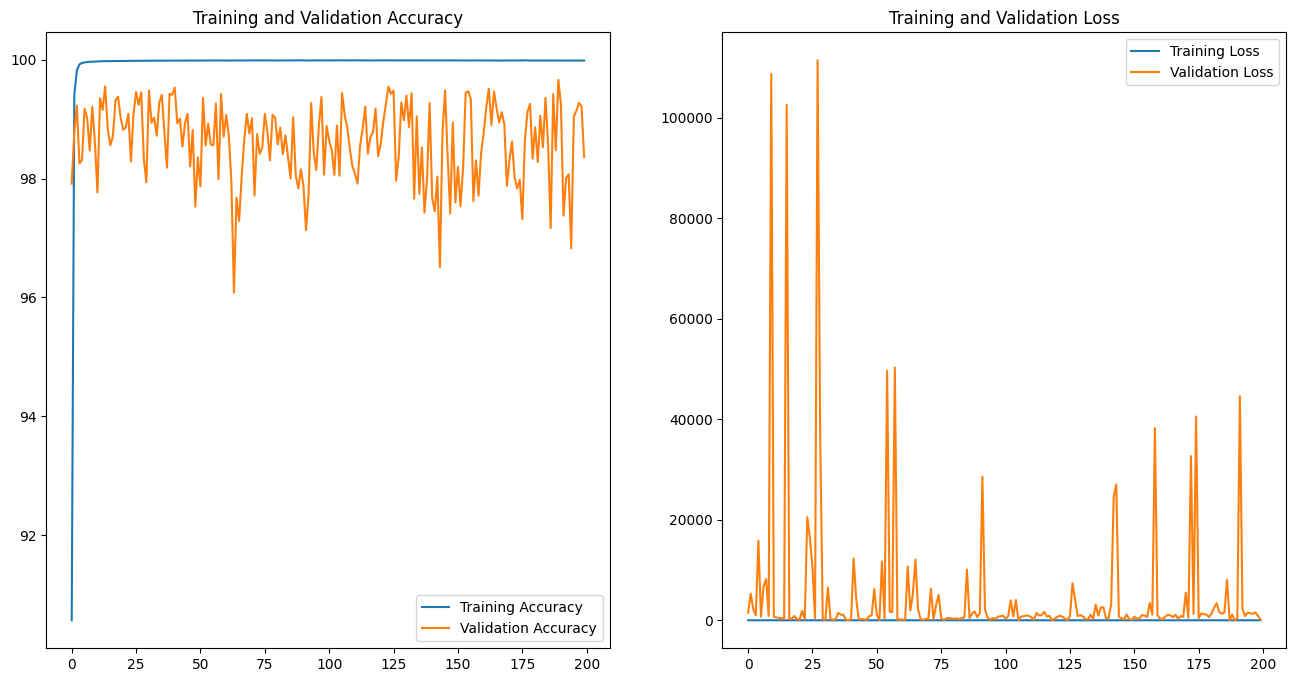

预测正确率: 0.9966145979659493


In [ ]:
x_train_2017 = np.load('/content/drive/MyDrive/x_train_2017.npy')
x_test_2017 = np.load('/content/drive/MyDrive/x_test_2017.npy')
y_train_2017 = np.load('/content/drive/MyDrive/y_train_2017.npy')
y_test_2017 = np.load('/content/drive/MyDrive/y_test_2017.npy')


if isinstance(x_train_2017, pd.DataFrame):
    x_train_2017 = x_train_2017.values
    x_test_2017 = x_test_2017.values

if isinstance(y_train_2017, pd.DataFrame):
    y_train_2 = y_train_2017.values
    y_test_2 = y_test_2017.values

train_ds = TensorDataset(torch.tensor(x_train_2017).float(), torch.tensor(y_train_2017).long())
test_ds = TensorDataset(torch.tensor(x_test_2017).float(), torch.tensor(y_test_2017).long())


class SelfAttention(nn.Module):
    def __init__(self, dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)

    def forward(self, x):
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)
        attention = F.softmax(q @ k.transpose(-2, -1) / x.size(-1)**0.5, dim=-1)
        return attention @ v
class DNNModel(nn.Module):
    def __init__(self, dim_num, nb_class, dropout_num, dropout_p):
        super().__init__()
        self.nor = nn.BatchNorm1d(dim_num)
        self.attention = SelfAttention(dim_num)
        self.lin1 = nn.Linear(dim_num, 512)  # Increase size
        self.lin2 = nn.Linear(dim_num + 512, 256)  # Adjust accordingly
        self.lin3 = nn.Linear(dim_num + 512 + 256, 128)  # Adjust accordingly
        self.lin4 = nn.Linear(dim_num + 512 + 256 + 128, 64)  # Adjust accordingly
        self.lin5 = nn.Linear(dim_num + 512 + 256 + 128 + 64, 32)  # Adjust accordingly
        self.lin6 = nn.Linear(dim_num + 512 + 256 + 128 + 64 + 32, 16)  # New layer
        self.lin7 = nn.Linear(dim_num + 512 + 256 + 128 + 64 + 32 + 16, 8)  # New layer
        # Adjust final layer to include input from all previous layers
        self.fc = nn.Linear(dim_num + 512 + 256 + 128 + 64 + 32 + 16 + 8, nb_class)
        self.flatten = nn.Flatten()
        self.dropouts = nn.ModuleList([nn.Dropout(dropout_p) for _ in range(dropout_num)])

    def forward(self, x):
        x = self.nor(x)
        attention_out = self.attention(x) + x

        out1 = F.relu(self.lin1(attention_out))
        concat1 = torch.cat([attention_out, out1], dim=1)

        out2 = F.relu(self.lin2(concat1))
        concat2 = torch.cat([concat1, out2], dim=1)

        out3 = F.relu(self.lin3(concat2))
        concat3 = torch.cat([concat2, out3], dim=1)

        out4 = F.relu(self.lin4(concat3))
        concat4 = torch.cat([concat3, out4], dim=1)

        out5 = F.relu(self.lin5(concat4))
        concat5 = torch.cat([concat4, out5], dim=1)

        out6 = F.relu(self.lin6(concat5))
        concat6 = torch.cat([concat5, out6], dim=1)

        out7 = F.relu(self.lin7(concat6))
        concat7 = torch.cat([concat6, out7], dim=1)

        flat_out = self.flatten(concat7)

        if len(self.dropouts) == 0:
            return self.fc(flat_out)
        else:
            out = None
            for i, dropout in enumerate(self.dropouts):
                if i == 0:
                    out = dropout(flat_out)
                    out = self.fc(out)
                else:
                    temp_out = dropout(flat_out)
                    out += self.fc(temp_out)
            return out / len(self.dropouts)

batch_size = 512
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


def train(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.to(torch.float32)
        loss = loss_fn(outputs, labels)  # 使用交叉熵损失函数计算损失
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels.argmax(dim=1)).sum().item()

    train_loss = total_loss / len(dataloader)
    train_acc = 100. * correct / total
    print('train', train_loss, 'acc', train_acc)
    return train_loss, train_acc

def test(dataloader, model, loss_fn):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            labels = labels.to(torch.float32)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels.argmax(dim=1)).sum().item()

    test_loss = total_loss / len(dataloader)
    test_acc = 100. * correct / total
    print('test', test_loss, 'acc', test_acc)
    return test_loss, test_acc


device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

dnn_model = DNNModel(dim_num=67, nb_class=7, dropout_num=8, dropout_p=0.5).to(device)
# [77054, 53700,  1377, 23681, 14077,  3569,  1287]
samples_per_class = np.array([2271320,  379737,      97,   23681,  158804,   13868,      11])
total_samples = samples_per_class.sum()
weights = total_samples / (len(samples_per_class) * samples_per_class)
print(weights)
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float).to(device))
# loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dnn_model.parameters(), lr= 1e-5, betas = (0.88, 0.98), weight_decay = 1e-6)


epochs = 200
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

best_accuracy = 0.0
#
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_correct = train(train_dl, dnn_model, loss_fn, optimizer)
    test_loss, test_correct = test(test_dl, dnn_model, loss_fn)

    if test_correct > best_accuracy:
        best_accuracy = test_correct
        torch.save(dnn_model.state_dict(), '/content/drive/MyDrive/best_dnn_model_2.pth')
        print(f"Higher accuracy found ({best_accuracy:.2f}%). Model saved.")

    train_loss_list.append(train_loss)
    train_acc_list.append(train_correct)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_correct)

acc = train_acc_list
val_acc = test_acc_list

loss = train_loss_list
val_loss = test_loss_list
epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

predict_list = []  # 存储预测结果
label_list = []  # 存储真实标签
predict_pro_list = []  # 存储预测概率

# 创建模型实例

# 加载最优模型参数
dnn_model.load_state_dict(torch.load('/content/drive/MyDrive/best_dnn_model_2.pth'))
dnn_model.eval()
m_softmax = nn.Softmax(dim=1)  # 定义softmax函数用于计算概率


# 遍历测试集
for (x, y) in test_dl:
    x = x.to(device)
    y = y.to(device)

    # 使用最优模型进行预测
    predict_score = dnn_model(x)
    predict_pro = m_softmax(predict_score)
    predict_label = torch.argmax(predict_score, dim=1)
    y = y.argmax(dim=1)
    # 将预测结果和真实标签添加到相应的列表中
    predict_list.append(predict_label.cpu().numpy())
    label_list.append(y.cpu().numpy())

# 将列表转换为数组
predict_array = np.concatenate(predict_list)
label_array = np.concatenate(label_list)

# 将独热编码转换为位置索引

# # 计算正确预测的样本数
correct_predictions = (predict_array == label_array).sum()
# # 计算总样本数
total_samples = len(label_array)  # 使用 label_index 的长度
# # 计算正确率
accuracy = correct_predictions / total_samples
#
print("预测正确率:", accuracy)
#

In [ ]:
acc = train_acc_list
val_acc = test_acc_list

loss = train_loss_list
val_loss = test_loss_list
epochs_range = range(epochs)

# plt.figure(figsize=(16, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

predict_list = []  # 存储预测结果
label_list = []  # 存储真实标签
predict_pro_list = []  # 存储预测概率

# 创建模型实例

# 加载最优模型参数
dnn_model.load_state_dict(torch.load('/content/drive/MyDrive/best_dnn_model_2.pth'))   #'/content/drive/MyDrive/best_dnn_model_2.pth'
dnn_model.eval()
m_softmax = nn.Softmax(dim=1)  # 定义softmax函数用于计算概率


# 遍历测试集
for (x, y) in test_dl:
    x = x.to(device)
    y = y.to(device)

    # 使用最优模型进行预测
    predict_score = dnn_model(x)
    predict_pro = m_softmax(predict_score)
    predict_label = torch.argmax(predict_score, dim=1)
    y = y.argmax(dim=1)
    # 将预测结果和真实标签添加到相应的列表中
    predict_list.append(predict_label.cpu().numpy())
    label_list.append(y.cpu().numpy())

# 将列表转换为数组
predict_array = np.concatenate(predict_list)
label_array = np.concatenate(label_list)

# 将独热编码转换为位置索引

# # 计算正确预测的样本数
correct_predictions = (predict_array == label_array).sum()
# # 计算总样本数
total_samples = len(label_array)  # 使用 label_index 的长度
# # 计算正确率
accuracy = correct_predictions / total_samples
#
print("预测正确率:", accuracy)
#

预测正确率: 0.9966145979659493


In [ ]:
predict_list = []  # 存储预测结果
label_list = []  # 存储真实标签
predict_pro_list = []  # 存储预测概率

## 分类报告

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 确保之前的代码已经执行，此处不再重复

# 将列表转换为数组
# predict_array = np.concatenate(predict_list)
# label_array = np.concatenate(label_list)

# 计算正确预测的样本数
correct_predictions = (predict_array == label_array).sum()
# 计算总样本数
total_samples = len(label_array)
# 计算正确率
accuracy = correct_predictions / total_samples
print("预测正确率: {:.4f}".format(accuracy))

# 打印分类报告
# 在classification_report中设置digits参数为4，以设置小数点后四位的精度
print("分类报告:")
print(classification_report(label_array, predict_array, digits=4))

# 计算并打印混淆矩阵
# 注意：混淆矩阵是整数，所以不需要设置小数位数
print("混淆矩阵:")
cm = confusion_matrix(label_array, predict_array)
print(cm)

预测正确率: 0.9966
分类报告:
              precision    recall  f1-score   support

           0     0.9994    0.9985    0.9990    227132
           1     0.9980    0.9918    0.9949     37974
           2     0.2800    0.7000    0.4000        10
           3     0.8597    0.9704    0.9117      2368
           4     0.9834    0.9883    0.9858     15880
           5     0.9306    0.9567    0.9435      1387
           6     0.0000    0.0000    0.0000         1

    accuracy                         0.9966    284752
   macro avg     0.7216    0.8008    0.7478    284752
weighted avg     0.9968    0.9966    0.9967    284752

混淆矩阵:
[[226799     22     10    157    143      1      0]
 [    88  37663      3    129     79     12      0]
 [     0      3      7      0      0      0      0]
 [    30      6      5   2298     27      2      0]
 [    13      6      0     83  15694     84      0]
 [     2     36      0      6     16   1327      0]
 [     0      1      0      0      0      0      0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
0.0020# 计算并打印混淆矩阵
print("混淆矩阵:")
cm = confusion_matrix(label_array, predict_array)

# 计算假警报率
FP = cm[1][0]
TN = cm[1][1]
false_alarm_rate = FP / (FP + TN)
print("假警报率: {:.4f}".format(false_alarm_rate))


混淆矩阵:
假警报率: 0.0023


In [ ]:
# 计算并打印混淆矩阵
print("混淆矩阵:")
cm = confusion_matrix(label_array, predict_array)

# 计算检测率
TP = cm[0][0]
FN = cm[0][1]
detection_rate = TP / (TP + FN)
print("检测率: {:.4f}".format(detection_rate))


混淆矩阵:
检测率: 0.9999


In [ ]:
# 计算并打印混淆矩阵
print("混淆矩阵:")
cm = confusion_matrix(label_array, predict_array)

# 计算假负例率
TP = cm[0][0]
FN = cm[0][1]
false_negative_rate = FN / (TP + FN)
print("假负例率: {:.4f}".format(false_negative_rate))


混淆矩阵:
假负例率: 0.0001


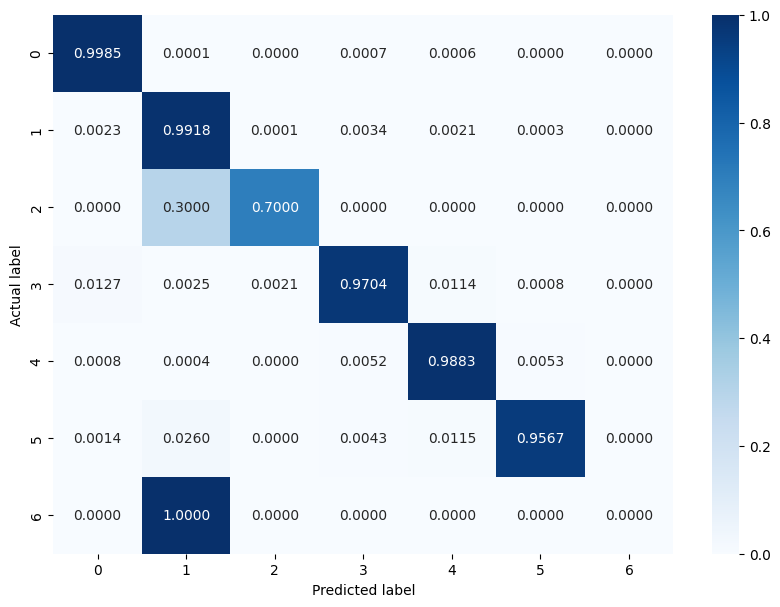

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import numpy as np

# 计算混淆矩阵
cm = confusion_matrix(label_array, predict_array)

# 将混淆矩阵转换为正确率矩阵
cm_rate = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 绘制热图
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rate, annot=True, fmt='.4f', cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
# 保存图像
# plt.savefig('/content/drive/MyDrive/Figure/confusion_matrix_NSL-KDD.png')  # 指定保存路径和文件名

# 显示图像
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# Assuming predict_array and label_array are already defined as shown in your code

# Calculate Accuracy
accuracy = accuracy_score(label_array, predict_array)
print("Accuracy:", accuracy)

# Calculate Precision
precision = precision_score(label_array, predict_array, average='weighted')
print("Precision:", precision)

# Calculate Recall
recall = recall_score(label_array, predict_array, average='weighted')
print("Recall:", recall)

# Calculate F1-Score
f1 = f1_score(label_array, predict_array, average='weighted')
print("F1-Score:", f1)


Accuracy: 0.9966145979659493
Precision: 0.9968113530903544
Recall: 0.9966145979659493
F1-Score: 0.9966792809770283


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# 分类准确率
from sklearn.metrics import confusion_matrix


# 计算每个类别的准确率
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, accuracy in enumerate(class_accuracy):
    print("类别{}的准确率: {:.4f}".format(i, accuracy))



类别0的准确率: 0.9985
类别1的准确率: 0.9918
类别2的准确率: 0.7000
类别3的准确率: 0.9704
类别4的准确率: 0.9883
类别5的准确率: 0.9567
类别6的准确率: 0.0000


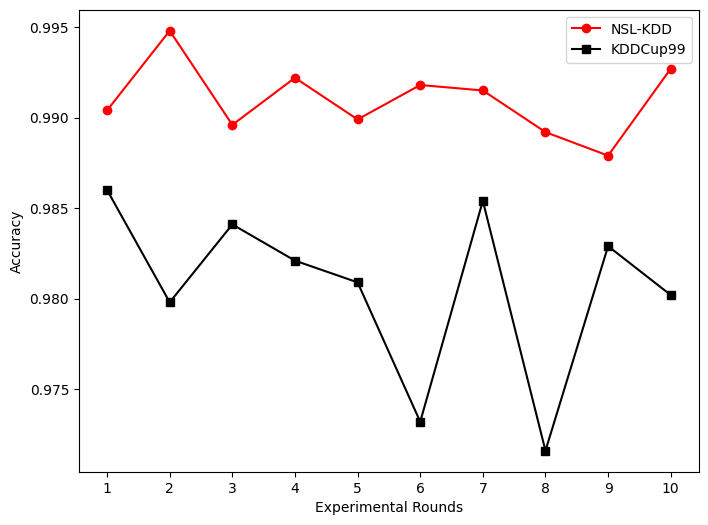

In [ ]:
import matplotlib.pyplot as plt

# Accuracy data for NSL-KDD and KDDCup99
nsl_kdd_accuracies = [0.9904, 0.9948, 0.9896, 0.9922, 0.9899, 0.9918, 0.9915, 0.9892, 0.9879, 0.9927]
kddcup99_accuracies = [0.9860, 0.9798, 0.9841, 0.9821, 0.9809, 0.9732, 0.9854, 0.9716, 0.9829, 0.9802]

# Set up the plot
plt.figure(figsize=(8, 6))
rounds = range(1, 11)  # 10 rounds of experiments

# Plotting the lines with specified colors
plt.plot(rounds, nsl_kdd_accuracies, 'o-', color='red', label='NSL-KDD')  # Red for NSL-KDD
plt.plot(rounds, kddcup99_accuracies, 's-', color='black', label='KDDCup99')  # Black for KDDCup99

# Adding labels and adjusting y-axis
plt.xlabel('Experimental Rounds')
plt.ylabel('Accuracy')
plt.xticks(range(1, 11))  # Ensure the x-axis labels match the number of rounds
# plt.ylim(0.910, 0.970)  # Adjust y-axis range
# plt.yticks([0.910, 0.920, 0.930, 0.940, 0.950, 0.960, 0.970])  # Set specific ticks for y-axis
plt.legend()

# Remove gridlines
plt.grid(False)

# Show the plot
plt.show()



